* Course: YSC4103 MCS Capstone
* Date created: 2019/02/25
* Name: Linfan XIAO
* Description: Implement the Fokas method as described in "Evolution PDEs and augmented eigenfunctions. Finite interval."

Let $C=C^{\infty}[0,1]$ be the set of functions with derivatives of all orders on $[0,1]$. 

Define $n$ linearly independent boundary forms $\{B_j: C\to\mathbb{C}\mid j\in\{1,2,\ldots,n\}\}$ as follows:
\begin{align*}
B_j\phi &= \sum_{k=0}^{n-1} \left(b_{jk}\phi^{(k)}(0) + \beta_{jk}\phi^{(k)}(1)\right),\quad j\in \{1,2,\ldots, n\},
\end{align*}
where $b_{jk}, \beta_{jk}\in\mathbb{R}$ are boundary coefficients. Define 
\begin{align*}
\Phi &= \{\phi\in C: B_j\phi = 0\,\forall j \in \{1,2,\ldots, n\}\}
\end{align*}
to be the set of $n$ homogeneous boundary conditions
\begin{align*}
\left(b_{11}\phi^{(0)}(0) + \beta_{11}\phi^{(0)}(1)\right) + \cdots +\left(b_{1n}\phi^{(n-1)}(0) + \beta_{1n}\phi^{(n-1)}(1)\right) &= 0\\
&\vdots\\
\left(b_{n1}\phi^{(0)}(0) + \beta_{n1}\phi^{(0)}(1)\right) + \cdots +\left(b_{nn}\phi^{(n-1)}(0) + \beta_{nn}\phi^{(n-1)}(1)\right) &= 0.
\end{align*}
Let $S:\Phi\to C$ be the linear differential operator 
$$S\phi(x) = (-i)^n \phi^{(n)}(x).$$

Let $a\in\mathbb{C}$ be a constant. Consider the homogeneous initial-boundary value problem (IBVP):
\begin{alignat*}{2}
(\partial_t + aS)q(x,t) &= 0,\quad&(x,t)\in (0,1)\times (0,T)\\
q(x,0)&\in\Phi,\quad &x\in [0,1]\\
q(\cdot, t) &\in\Phi,\quad &t\in [0,T]
\end{alignat*}
Let $f(x):=q(x,0)$. We reqire that if $n$ is odd then $a=\pm i$ and if $n$ is even then $\Re(a)\geq 0$. We solve the IBVP for $q(x,t)$.

# Importing packages

In [1]:
using SymPy
using PyCall
sympy = pyimport("sympy")
# using Roots
using Distributions
# using IntervalArithmetic
# using IntervalRootFinding
using ApproxFun

using Plots

using NBInclude
using QuadGK
import QuadGK.quadgk
# using HCubature
using ApproxFun
using Roots
using Gadfly
using PyPlot
# pygui(true)

# Global variables

## `TOL`

Error tolerance level.

In [2]:
TOL = 1e-05

1.0e-5

## `DIGITS`

The number of digits to display in symbolic expressions.

In [314]:
DIGITS = 3

3

## `INFTY`

A number representing infinity in numerical approximations.

In [4]:
INFTY = 10

10

## `t`

Free symbol in the unknown function $x(t)$ in the differential equation $Lx=0$.

In [5]:
# t = symbols("t")

## `sympy_Expr`s

Sample expressions of type addition, multiplication, power, and exponential in `SymPy`.

In [6]:
x = symbols("x")
sympyAddExpr = 1 + x

x + 1

In [7]:
sympyMultExpr = 2*x

2*x

In [8]:
sympyPowerExpr = x^2

 2
x 

In [9]:
sympyExpExpr = e^x

 x
e 

# Helper functions

## `check_all(array, condition)`

Checks whether all elements in an array satisfy a given condition.

In [10]:
function check_all(array, condition)
    for x in array
        if !condition(x)
            return false
        end
    end
    return true
end

check_all (generic function with 1 method)

**Parameters**
* `array`: `Array`
    * Input array to be checked. Generic, not necessarily homogeneous.
* `condition`: `Function: Bool`
    * Boolean function to be applied to each element in the array.

**Returns**
* `check_all`: `Bool`
    * Returns `true` if all elements in `array` satisfy `condition` and `false` if any element does not satisfy the condition.
    
**Example**

In [11]:
array = [0,1,2,3]
condition = x -> x>2
check_all(array, condition)

false

## `check_any(array, condition)`

Checks whether any element in an array satisfy a given condition.

In [12]:
function check_any(array, condition)
    for x in array
        if condition(x)
            return true
        end
    end
    return false
end

check_any (generic function with 1 method)

**Parameters**
* `array`: `Array`
    * Input array to be checked. Generic, not necessarily homogeneous.
* `condition`: `Function: Bool`
    * Boolean function to be applied to each element in the array.

**Returns**
* `check_all`: `Bool`
    * Returns `true` if there exists an element in the array that satisfies a given condition and `false` if no element satisfies the condition.
    
**Example**

In [13]:
array = [0,1,2,3]
condition = x -> x>2
check_any(array, condition)

true

## `set_tol(x, y)`

Sets an appropriate tolerance for checking whether two numbers or two arrays of numbers are approximately equal.

In [14]:
function set_tol(x::Union{Number, Array}, y::Union{Number, Array}; atol = TOL)
    if isa(x, Number) && isa(y, Number)
       return atol * mean([x y])
    elseif isa(x, Array) && isa(y, Array)
        if size(x) != size(y)
            throw(error("Array dimensions do not match"))
        end
        # Avoid InexactError() when taking norm()
        x = convert(Array{Complex}, x)
        y = convert(Array{Complex}, y)
        return atol * (norm(x,2) + norm(y,2))
    else
        throw(error("Invalid input"))
    end
end

set_tol (generic function with 1 method)

**Parameters**
* `x`, `y`: `Number` or `Array` of `Number`
    * Objects to compare.

**Returns**
* `set_tol`: `Number`
    * Returns a tolerance within which `x` and `y` are considered approximately equal (entry-wise if `x`, `y` are arrays).

**Example**

In [15]:
x = 14
y = 21
set_tol(x,y)

0.00017500000000000003

In [16]:
A = [4 0.6; 3 2]
B = [5 1; 10 3]
set_tol(A, B)

0.00016901192145623727

## `evaluate(func, a)`

Evaluate a univariate function or an array of them at a given value.

In [17]:
function evaluate(func::Union{Function,Number,Array}, a::Number)
    if !isa(func, Array)
        if isa(func, Function)
            funcA = func(a)
        elseif isa(func, SymPy.Sym) # SymPy.Sym must come before Number because SymPy.Sym will be recognized as Number
            freeSymbols = free_symbols(func)
            if length(freeSymbols) > 1
                throw(error("func should be univariate"))
            elseif length(freeSymbols) == 1
                t = free_symbols(func)[1,1]
                if isa(a, SymPy.Sym) # if x is SymPy.Sym, do not convert result to Number to preserve pretty printing
                    funcA = subs(func, t, a)
                else
                    funcA = SymPy.N(subs(func, t, a))
                end
            else
                funcA = func
            end
        else # func is Number
            funcA = func
        end
        return funcA
    else
        (m, n) = size(func)
        if check_any(func, x->isa(x, SymPy.Sym))
            funcA = Array{SymPy.Sym}(m,n)
        else
            funcA = Array{Number}(m,n) 
        end
        for i = 1:m
            for j = 1:n
                funcA[i,j] = evaluate(func[i,j], a)
            end
        end
        return funcA
    end
end

evaluate (generic function with 1 method)

**Parameters**
* `func`: `Function`, `SymPy.Sym`, `Number`, or `Array`
    * Object to be evaluated. Note that `SymPy.Sym` is absorbed into `Number`.
* `x`: `Number`
    * Value on which `func` is to be evaluated at.
* `t`: `SymPy.Sym` 
    * Free symbol in `func` if `func` is a `SymPy.Sym` object or an array of them.

**Returns**
* `evaluate`: `Number`
    * Returns the value of `func` at `x`.

**Example**

In [18]:
func = x -> x+1
evaluate(func, 2)

3

In [19]:
x = symbols("x")
func = x+1
evaluate(func, 2)

3

In [20]:
a = symbols("a")
evaluate(func, a)

a + 1

In [21]:
x = symbols("x")
array = [2x 1; x^3 x]
a = symbols("a")
evaluate(array, a)

2×2 Array{SymPy.Sym,2}:
 2*a  1
 a^3  a

## `partition(n)`

Generate ordered two-integer partitions ($0$ included) of a given non-negative integer.

In [22]:
function partition(n::Int)
    if n < 0
        throw(error("Non-negative n required"))
    end
    output = []
    for i = 0:n
        j = n - i
        push!(output, (i,j))
    end
    return output
end

partition (generic function with 1 method)

**Parameters**
* `n`: `Int`
    * Non-negative integer to be partitioned.

**Returns**
* `partition`: `Array` of `Tuple{Int, Int}`
    * Returns an array of tuples, where each tuple corresponds to a two-integer parition of `n`. Note that a tuple is ordered, and `(i, j)` and `(j, i)` are considered distinct partitions.

**Example**

In [23]:
n = 5
partition(5)

6-element Array{Any,1}:
 (0, 5)
 (1, 4)
 (2, 3)
 (3, 2)
 (4, 1)
 (5, 0)

## `get_symDeriv(u, t, k)`

Constructs the symbolic expression for the $k$th derivative of a univariate function.

In [24]:
function get_symDeriv(u::SymPy.Sym, t::SymPy.Sym, k::Int)
    if k < 0
        throw(error("Non-negative k required"))
    end
    y = u
    for i = 1:k
        newY = diff(y, t)
        y = newY
    end
    return y
end

get_symDeriv (generic function with 1 method)

**Parameters**
* `u`: `SymPy.Sym` 
    * Symbolic expression in `t` to be differentiated.
* `t`: `SymPy.Sym`
    * Free symbol in `u`.
* `k`: `Int`
    * Degree of the desired derivative.

**Returns**
* `get_symDeriv`: `SymPy.Sym`
    * Returns the symbolic expression of $\frac{d^k}{dt^k}u(t)$.
    
**Example**

In [25]:
t = symbols("t")
u = t^2+2t+3
get_symDeriv(u, t, 1)

2*t + 2

## `add_func(f, g)`

Computes the sum of two functions using the function addition given by $(f + g)(x) := f(x) + g(x)$.

In [26]:
function add_func(f::Union{Number, Function}, g::Union{Number, Function})
    function h(x)
        if isa(f, Number)
            if isa(g, Number)
                return f + g
            else
                return f + g(x)
            end
        elseif isa(f, Function)
            if isa(g, Number)
                return f(x) + g
            else
                return f(x) + g(x)
            end
        end
    end
    return h
end

add_func (generic function with 1 method)

**Parameters**
* `f`, `g`: `Function` or `Number`
    * Functions to be added.

**Returns**
* `add_func`: `Function` or `Number`
    * Returns the sum of `f` and `g`.

**Example**

In [27]:
f(x) = x^3+1
g(x) = 4x
x = 2
add_func(f, g)(x) == f(x) + g(x)

true

## `mult_func(f, g)`

Computes the product of two functions using the function multiplication given by $(f \cdot g)(x) := f(x) \cdot g(x)$.

In [28]:
function mult_func(f::Union{Number, Function}, g::Union{Number, Function})
    function h(x)
        if isa(f, Number)
            if isa(g, Number)
                return f * g
            else
                return f * g(x)
            end
        elseif isa(f, Function)
            if isa(g, Number)
                return f(x) * g
            else
                return f(x) * g(x)
            end
        end
    end
    return h
end

mult_func (generic function with 1 method)

**Parameters**
* `f`, `g`: `Function` or `Number`
    * Functions to be multiplied.

**Returns**
* `add_func`: `Function` or `Number`
    * Returns the product of `f` and `g`.

**Example**

In [29]:
f(x) = x^3+1
g(x) = 4x
x = 2
mult_func(f, g)(x) == f(x) * g(x)

true

## `get_polynomial(coeffList)`

Given the array $[a_n, a_{n-1}, \ldots, a_1, a_0]$, constructs the polynomial 
$$a_nx^n + a_{n-1}x^{n-1} + \cdots + a_1 x + a_0.$$

In [30]:
function get_polynomial(coeffList::Array)
    polynomial = 0
    n = length(coeffList)-1
    for i in 0:n
        newTerm = t -> coeffList[i+1] * t^(n-i)
        polynomial = add_func(polynomial, newTerm)
    end
    return polynomial
end

get_polynomial (generic function with 1 method)

**Parameters**
* `coeffList`: `Array` of `Number`
    * Array of coefficients of $x^n, x^{n-1}, \ldots, x, 1$ in the polynomial.

**Returns**
* `get_polynomial: Function`
    * Returns a polynomial whose coefficients are given by `coeffList`.
 
**Example**

In [31]:
coeffList = [0,1,2,3]
x = 5
get_polynomial(coeffList)(x) == 0*x^3 + 1*x^2 + 2*x^1 + 3*x^0

true

## `get_polynomialDeriv(coeffList, k)`

Computes the $k$th derivative of a polynomial with known coefficients.

In [32]:
function get_polynomialDeriv(coeffList::Array, k::Int)
    if k < 0
        throw(error("Non-negative degree required"))
    elseif k == 0
        newCoeffList = coeffList
    else
        for counter = 1:k
            n = length(coeffList)
            newCoeffList = hcat([0],[(n-i)*coeffList[i] for i in 1:(n-1)]')
            coeffList = newCoeffList
        end
    end
    return get_polynomial(newCoeffList)
end

get_polynomialDeriv (generic function with 1 method)

**Parameters**
* `coeffList`: `Array` of `Number` 
    * Array of coefficients of $x^n, x^{n-1}, \ldots, x, 1$ in the polynomial.
* `k`: `Int` 
    * Degree of the desired derivative.

**Returns**
* `get_polynomialDeriv`: `Function`
    * Returns the $k$th derivative of the polynomial whose coefficients are given by `coeffList`.

**Example**

In [33]:
coeffList = [0,1,2,3]
k = 1
x = 5
get_polynomialDeriv(coeffList, k)(x) == 2*x^1 + 2*x^0

true

## `sym_to_func(sym)`

Converts a univariate symbolic expression or an array of them to their function counterparts.

In [34]:
function sym_to_func(sym::Union{Number, Array})
    if isa(sym, SymPy.Sym)
        freeSymbols = free_symbols(sym)
        if length(freeSymbols) > 1
            throw(error("sym should be univariate"))
        else
            function func(x)
                if length(freeSymbols) == 0
                    result = SymPy.N(sym)
                else
                    result = SymPy.N(subs(sym, freeSymbols[1], x))
                end
                return result
            end
            return func
        end
    else
        func = [sym_to_func(s) for s in sym]
        return func
    end
end

# function sym_to_func(expr::SymPy.Sym)
#     if length(free_symbols(expr)) == 0
#         result = SymPy.N(expr)
#     else
#         result = SymPy.lambdify(expr)
#     end
#     return result
# end

sym_to_func (generic function with 1 method)

**Parameters**
* `sym`: `SymPy.Sym` or `Array` of `SymPy.Sym`
    * Symbolic expression or an array of them to be converted.

**Returns**
* `sym_to_func`: `Function`
    * Function or an array of them converted from `sym`.

**Example**

In [35]:
t = symbols("t")
sym = t^2+t
sym_to_func(sym)(2)

6

In [36]:
sym = [1 t; t^2 t^3]
sym_to_func(sym)[2,1](2)

4

## `prettyRound(x, digits)`

Round a number at a given number of digits.

In [395]:
function prettyRound(x::Number; digits::Int = DIGITS)
    if isa(x, Int)
        return x
    elseif isa(x, Real)
        if isa(x, Rational) || isa(x, Irrational) # If x is rational or irrational numbers like e, pi
            return x
        elseif round(abs(x), digits) == floor(abs(x))
            return Int(round(x))
        else
            return round(x, digits)
            # return rationalize(x)
        end
    elseif isa(x, Complex)
        roundedReal = prettyRound(real(x), digits = digits)
        roundedComplex = prettyRound(imag(x), digits = digits)
        return roundedReal + im*roundedComplex
    else
        return round(x, digits)
    end
end

prettyRound (generic function with 2 methods)

**Parameters**
* `x`: `Number`
    * Number to be rounded.
* `digits*`: `Int`
    * Number of decimal places to keep. Default to the global variable `DIGITS`.

**Returns**
* `prettyRound`: `Number`
    * Returns `x` rounded to the `digits` decimal places.

**Example**

In [315]:
x = 0.0000001*im
prettyRound(x)

0 + 0im

In [317]:
x = 1/3
prettyRound(x)

0.33

In [316]:
x = 1//3
prettyRound(x)

1//3

## `prettyPrint(x)`

Prints a symbolic scalar or array with pretty-rounded floating numbers.

In [327]:
function prettyPrint(x::Union{Number, SymPy.Sym, Array})
    if !isa(x, Array)
        expr = x
        if isa(expr, SymPy.Sym)
            prettyExpr = expr
            for a in sympy[:preorder_traversal](expr)
                if length(free_symbols(a)) == 0 && length(args(a)) == 0
                    if !(a in [e, PI]) && length(intersect(args(a), [e, PI])) == 0 # keep the transcendental numbers as symbols
                        prettyA = prettyRound(SymPy.N(a))
                        prettyExpr = subs(prettyExpr, (a, prettyA))
                    end
                end
            end
        else
            prettyExpr = prettyRound(expr)
            prettyExpr = convert(SymPy.Sym, prettyExpr)
        end
        return prettyExpr
    else
        array = x
        # (m, n) = size(array) # n would not be assinged if array is an mx1 vector
        m, n = size(array, 1), size(array, 2)
        prettyArray = Array{SymPy.Sym}(m,n)
        for i = 1:m
            for j = 1:n
                prettyArray[i,j] = prettyPrint(array[i,j])
            end
        end
        return prettyArray
    end
end

prettyPrint (generic function with 1 method)

**Parameters**
* `x`: `Number`, `SymPy.Sym`, or `Array` of `Number` or `SymPy.Sym`
    * Object to be printed.

**Returns**
* `prettyPrint`: `SymPy.Sym` or `Array` of `SymPy.Sym`
    * Returns symbolic expression of `x` with pretty-rounded floating numbers.

**Example**

In [330]:
t = symbols("t")
x = 1//3*t + e^(2t) + PI/2 + 1.00001*im + sympy[:sqrt](2) + 1//6
prettyPrint(x)

t    2*t   1     ___   pi    
- + e    + - + \/ 2  + -- + I
3          6           2     

In [41]:
t = symbols("t")
x = [1/3*t PI; 1/6*t^2+t 1]
prettyPrint(x)

2×2 Array{SymPy.Sym,2}:
       0.33*t  pi
 0.17*t^2 + t   1

In [204]:
x = [0.0+1.0*im 1.0+0.0*im -1.0+0.0*im 0.0-1.0*im]
prettyPrint(x)

1×4 Array{SymPy.Sym,2}:
 I  1  -1  -I

In [379]:
prettyPrint(-1.83697e-16+0.0im)

0.0

## `is_approxLess(x, y; atol)`

Checks whether $x$ is approximately less than $y$ within a tolerance. That is, whether $x\not\approx y$ and $x<y$.

In [43]:
function is_approxLess(x::Number, y::Number; atol = TOL)
    return !isapprox(x,y; atol = atol) && x < y
end

is_approxLess (generic function with 1 method)

**Parameters**
* `x`, `y`: `Number`
    * Numbers to compare.
* `atol*`: `Number`
    * Tolerance within which $x$ would be considered approximately equal to $y$. Default to the global variable `TOL`.

**Returns**
* `is_approxLess`: `Bool`
    * Returns `true` if $x\not\approx y$ within `atol` and $x<y$, and `false` otherwise.

**Example**

In [44]:
x = 1
y = x + TOL/2
is_approxLess(x,y)

false

In [45]:
y = x + TOL*2
is_approxLess(x,y)

true

## `is_approx(x, y; atol)`

Checks whether $x$ is approximately equal to $y$ within a tolerance.

In [46]:
function is_approx(x::Number, y::Number; atol = TOL)
    return isapprox(x, y; atol = atol)
end

is_approx (generic function with 1 method)

**Parameters**
* `x`, `y`: `Number`
    * Numbers to compare.
* `atol*`: `Number`
    * Tolerance within which $x$ would be considered approximately equal to $y$. Default to the global variable `TOL`.

**Returns**
* `is_approx`: `Bool`
    * Returns `true` if $x\approx y$ within `atol` and `false` otherwise.

**Example**

In [47]:
x = 1
y = x + TOL/2
is_approx(x,y)

true

In [48]:
x = 1
y = x + TOL*2
is_approx(x,y)

false

## `argument(z)`

Finds the argument of a complex number in $[0,2\pi)$.

In [371]:
function argument(z::Number)
    if angle(z) >= 0 # in [0,pi]
        return angle(z)
    else 
        # angle(z) is in (-pi, 0]
        # Shift it up to (pi,2pi]
        argument = 2pi + angle(z) # This is in (pi,2pi]
        if is_approx(argument, 2pi) # Map 2pi to 0
            return 0
        else
            return argument # This is now in [0,2pi)
        end
    end
end

argument (generic function with 1 method)

**Parameters**
* `z`: `Number`
    * Complex number whose argument is to be found.

**Returns**
* `argument`: `Number`
    * Returns $\arg(z)$ in $[0,2\pi)$.
    
**Example**

In [50]:
z = 1
argument(z)

0.0

In [372]:
z = -1-im
argument(z)

3.9269908169872414

## `trace_contour(a, n, infty, sampleSize)`

Plots the contour sectors encircled by $\Gamma_a^+$, $\Gamma_a^-$, $\Gamma_0^+$, and $\Gamma_0^-$ defined as
\begin{align*}
    \Gamma_a^{\pm} &:= \partial(\{\lambda\in\mathbb{C}^{\pm}:\, \Re(a\lambda^n)>0\}\setminus \bigcup_{\substack{\sigma\in\mathbb{C};\\\Delta(\sigma)=0}} D(\sigma, 2\epsilon))\quad\mbox{($D$ for disk)},\\
    \Gamma_0^+ &:= \bigcup_{\substack{\sigma\in\overline{\mathbb{C}^+};\\ \Delta(\sigma)=0}} C(\sigma, \epsilon)\quad\mbox{($C$ for circle)},\\
    \Gamma_0^- &:= \bigcup_{\substack{\sigma\in\mathbb{C}^-;\\ \Delta(\sigma)=0}} C(\sigma, \epsilon)
\end{align*}
by sampling points.

In [52]:
function trace_contour(a::Number, n::Int, sampleSize::Int; infty = INFTY)
    lambdaVec = []
    for counter = 1:sampleSize
        x = rand(Uniform(-infty,infty), 1, 1)[1]
        y = rand(Uniform(-infty,infty), 1, 1)[1]
        lambda = x + y*im
        if real(a*lambda^n)>0
            append!(lambdaVec, lambda)
        end
    end
    Gadfly.plot(x=real(lambdaVec), y=imag(lambdaVec), Guide.xlabel("Re"), Guide.ylabel("Im"), Coord.Cartesian(ymin=-infty,ymax=infty, xmin=-infty, xmax=infty, fixed = true))
end

trace_contour (generic function with 1 method)

**Parameters**
* `a`: `Number`
    * Complex number.
* `n`: `Int`
    * Integer $n$ in $\Gamma_a^{\pm}$.
* `infty`: `Number`
    * Range of plot. Default to the global variable `INFTY`.
* `sampleSize`: `Int`
    * Number of points to sample.

**Returns**
* `trace_contour`: `None`
    * Plots the sampled points.

**Example**

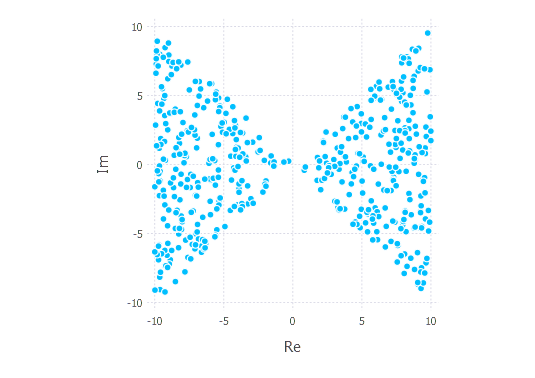

In [53]:
n = 2
a = 1
sampleSize = 1000
trace_contour(a, n, sampleSize)

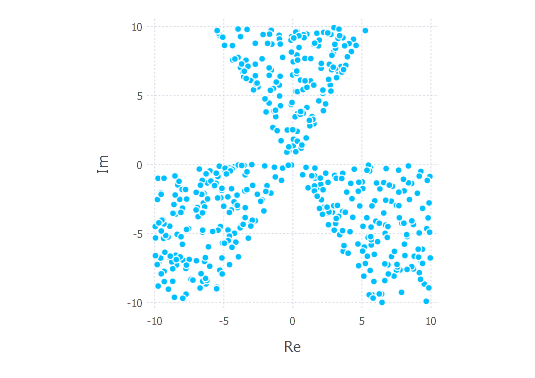

In [54]:
n = 3
a = im
sampleSize = 1000
trace_contour(a, n, sampleSize)

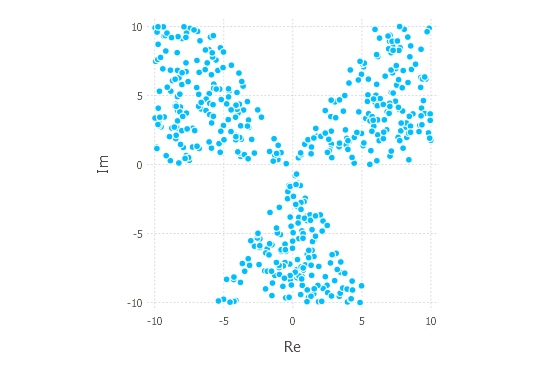

In [55]:
n = 3
a = -im
sampleSize = 1000
trace_contour(a, n, sampleSize)

## `get_distancePointLine(z, theta)`

Finds the distance between a complex number and a line through the origin given by an angle in $[0,2pi)$.

In [56]:
function get_distancePointLine(z::Number, theta::Number)
    if theta >= 2pi && theta < 0
        throw(error("Theta must be in [0,2pi)"))
    else
        if is_approx(argument(z), theta)
            return 0
        else
            x0, y0 = real(z), imag(z)
            if is_approx(theta, pi/2) || is_approx(theta, 3pi/2)
                return abs(x0)
            elseif is_approx(theta, 0) || is_approx(theta, 2pi)
                return abs(y0)
            else
                k = tan(theta)
                x = (y0+1/k*x0)/(k+1/k)
                y = k*x
                distance = norm(z-(x+im*y))
                return distance
            end
        end
    end
end

get_distancePointLine (generic function with 1 method)

**Parameters**
* `z`:  `Number`
    * Point in the complex plane.
* `theta`: `Number`
    * Line passing the origin given by the argument of any point (besides the origin) on it.

**Returns**
* `get_distancePointLine`: `Number`
    * Returns the distance between `z` and the line characterized by `theta`.

**Example**

In [57]:
z = 1
theta = pi/3
get_distancePointLine(z, theta) # sqrt(3)/2

0.8660254037844386

## `get_ChebyshevApproximation(f, interval; symbolic)`

Computes the Chebyshev approximation of a function $f$ on interval $[a,b]$ or its symbolic expression.

Note that the coefficients are obtained by shifting the interval $[a,b]$ to $[-1,1]$ and then back. That is, define $g:[a,b]\to [-1,1]$ by $g(x) = \frac{2(x-a)}{b-a}-1$. For $t\in [-1,1]$, define $q(t)=f\circ g^{-1}(t) = f(g^{-1}(t)) =: f(x)$ for $x\in [a,b]$. Then the Chebyshev coefficients are $\{b_0,\ldots, b_N\}$ in
$$f(x) = f\circ g^{-1}(g(x)) = q(g(x)) = q(t) = \sum_{n=0}^N b_n T_n(t) = \sum_{n=0}^N b_n T_n(g(x))$$
instead of $\{a_0,\ldots, a_N\}$ in
$$f(x) = \sum_{n=0}^N a_n T_n(x).$$

### `shift_interval(originalInterval; symbolic)`

Shifts a point in the interval $[a,b]$ to a corresponding point in $[-1,1]$.

In [58]:
function shift_interval(originalInterval::Tuple{Number,Number}; symbolic = true)
    (a,b) = originalInterval
    (c,d) = (-1,1)
    if symbolic
        x = symbols("x")
        return (d-c)*(x-a)/(b-a)+c
    else
        return x -> (d-c)*(x-a)/(b-a)+c
    end
end

shift_interval (generic function with 1 method)

**Parameters**
* `originalInterval`: `Tuple{Number,Number}`
    * Original interval $[a,b]$ to be shifted to $[-1,1]$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.

**Returns**
* `shift_interval`: `Function` or `SymPy.Sym`
    * Returns a function that shifts its argument $x$ in $[a,b]$ to a point in $[-1,1]$ if `symbolic = false` or a symbolic expression in $x$ if `symbolic = true`.

**Example**

In [59]:
(a,b) = (0,1)
shift_interval((a,b); symbolic = true)

2*x - 1

In [60]:
shift_interval((a,b); symbolic = false)(1/2)

0.0

### `get_ChebyshevSeriesTerm(n; symbolic)`

The Chebyshev polynomials are given by
\begin{align*}
    T_n(x) =
\begin{cases}
    \cos(n\cdot \arccos(x))&\quad\mbox{$|x|\leq 1$}\\
    \frac{1}{2}\left((x-\sqrt{x^2-1})^n + (x+\sqrt{x^2-1})^n\right)&\quad\mbox{$|x|>1$}.
\end{cases}   
\end{align*}
Obtains the $n$th term in the Chebyshev series expansion on $[-1,1]$ as a function or its symbolic expression.

In [61]:
function get_ChebyshevTerm(n::Int64; symbolic = true)
    if symbolic
        x = symbols("x")
        return cos(n*acos(x))
    else
        return x -> cos(n*acos(x))
    end
end

get_ChebyshevTerm (generic function with 1 method)

**Parameters**
* `n`: `Int`
    * $n$ in $T_n(x)$ on $[-1,1]$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.

**Returns**
* `get_ChebyshevTerm`: `Function` or `SymPy.Sym`
    * Returns$T_n(x)$ as a function if `symbolic = false` and `SymPy.Sym` if `symbolic = true`.
    
**Example**

In [62]:
get_ChebyshevTerm(2; symbolic = true)

cos(2*acos(x))

In [63]:
get_ChebyshevTerm(2; symbolic = false)

(::#24) (generic function with 1 method)

### `get_ChebyshevApproximation(f, interval; symbolic)`

Computes the Chebyshev approximation of a function $f$ on an interval $[a,b]$.

In [64]:
function get_ChebyshevApproximation(f::Function, interval::Tuple{Number,Number}; symbolic = true)
    (a,b) = interval
    fCheb = ApproxFun.Fun(f, a..b) # Approximate f on [a,b] using chebyshev polynomials
    chebCoefficients = ApproxFun.coefficients(fCheb) # get coefficients of the Chebyshev polynomial
    n = length(chebCoefficients)
    if symbolic
        fChebApproxSym = 0
        for i = 1:n
            chebCoefficient = chebCoefficients[i]
            chebTermSym = get_ChebyshevTerm(i-1; symbolic = true)
            x = free_symbols(chebTermSym)
            if !isempty(x)
                x = x[1,1] # Assume there is only one free symbol
            end
            # Chebyshev approximation is best on [-1,1]. Thus, we compute the Chebyshev approximation on [a,b] by shifting [a,b] to [-1,1] and evaluating the Chebyshev approximation there.
            # Here, we do that by replacing x in the symbolic expression with the symbolic expression after the interval shift.
            fChebApproxSym += chebCoefficient * subs(chebTermSym, x, shift_interval((a,b); symbolic = symbolic))
        end
        return fChebApproxSym
    else
        function fChebApprox(x)
            sum = 0
            for i = 1:n
                chebCoefficient = chebCoefficients[i]
                # Here, we compose the interval shift function with the Chebyshev term.
                chebTerm = get_ChebyshevTerm(i-1; symbolic = false)
                summand = mult_func(chebCoefficient, x -> chebTerm(shift_interval((a,b); symbolic = symbolic)(x)))
                # summand = mult_func(chebCoefficient, chebTerm) # this is wrong
                sum = add_func(sum, summand)
            end
            return sum(x)
        end
        function finalChebApprox(x)
            if x >= a && x <= b # x in [a,b]
                return fChebApprox(x)
            else # if x is outside [a,b], make the approximation 0
                return 0.0
            end
        end
        return finalChebApprox
    end
end

get_ChebyshevApproximation (generic function with 1 method)

**Parameters**
* `f`: `Function`
    * Function to be approximated using Chebyshev polynomials.
* `interval`: `Tuple{Number, Number}`
    * Interval on which the Chebyshev approximation is defined. Outside the interval, the Chebyshev approximation is set as $0$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.

**Returns**
* `get_ChebyshevApproximation`: `Function` or `SymPy.Sym`
    * Returns the Chebyshev approximation of `f` as a function if `symbolic = false` or symbolic expression if `symbolic = true`.

**Example**

In [65]:
f(x) = x^2+1
interval = (0,1)
fChebApprox = get_ChebyshevApproximation(f, interval; symbolic = false)

(::finalChebApprox) (generic function with 1 method)

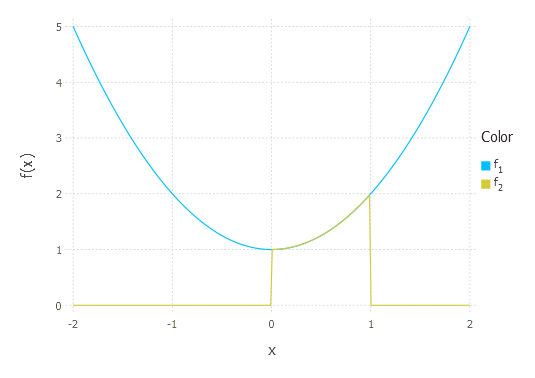

In [66]:
Gadfly.plot([f, fChebApprox], -2, 2)

# Structs

## `StructDefinitionError`

A struct definition error type is the class of all errors in struct definitions.

In [67]:
struct StructDefinitionError <: Exception
    msg::String
end

## `SymLinearDifferentialOperator(symPFunctions, interval, t)`

A symbolic linear differential operator of order $n$ is encoded by an $1 \times (n+1)$ array of symbolic expressions with at most one free symbol, an interval $[a,b]$, and that free symbol.

In [68]:
struct SymLinearDifferentialOperator
    # Entries in the array should be SymPy.Sym or Number. SymPy.Sym seems to be a subtype of Number, i.e., Array{Union{Number,SymPy.Sym}} returns Array{Number}. But specifying symPFunctions as Array{Number,2} gives a MethodError when the entries are Sympy.Sym objects.
    symPFunctions::Array
    interval::Tuple{Number,Number}
    t::SymPy.Sym
    SymLinearDifferentialOperator(symPFunctions::Array, interval::Tuple{Number,Number}, t::SymPy.Sym) =
    try
        symL = new(symPFunctions, interval, t)
        check_symLinearDifferentialOperator_input(symL)
        return symL
    catch err
        throw(err)
    end
end

function check_symLinearDifferentialOperator_input(symL::SymLinearDifferentialOperator)
    symPFunctions, (a,b), t = symL.symPFunctions, symL.interval, symL.t
    for symPFunc in symPFunctions
        if isa(symPFunc, SymPy.Sym)
            if size(free_symbols(symPFunc)) != (1,) && size(free_symbols(symPFunc)) != (0,)
                throw(StructDefinitionError(:"Only one free symbol is allowed in symP_k"))
            end
        elseif !isa(symPFunc, Number)
            throw(StructDefinitionError(:"symP_k should be SymPy.Sym or Number"))
        end
    end
    return true
end

check_symLinearDifferentialOperator_input (generic function with 1 method)

**Parameters**
* `symPFunctions`: `Array` of `SymPy.Sym` or `Number`
    * Array $[symP_0, symP_1, \ldots, symP_n]$ of length $n+1$, corresponding to the symbolic linear differential operator $symL$ of order $n$ given by 
    $$symLx = symP_0x^{(n)} + symP_1x^{(n-1)} + \cdots + symP_{n-1}x^{(1)} + symP_n x.$$
* `interval`: `Tuple{Number, Number}` 
    * Tuple of two numbers $(a,b)$ corresponding to the real interval $[a,b]$ on which the symbolic differential operator $symL$ is defined.
* `t`: `SymPy.Sym` 
    * Free symbol in each entry of `symPFunctions`.

**Returns**
* `SymLinearDifferentialOperator`
    * Returns a `SymLinearDifferentialOperator` of order $n$ with attributes `symPFunctions`, `interval`, and `t`.

**Example**

In [69]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)

SymLinearDifferentialOperator(SymPy.Sym[1 t + 1 t^2 + t + 1], (0, 1), t)

## `LinearDifferentialOperator(pFunctions, interval, symL)`

A linear differential operator $L$ of order $n$ given by 
$$Lx = p_0x^{(n)} + p_1x^{(n-1)} + \cdots + p_{n-1}x^{(1)} + p_n x$$
is encoded by an $1 \times (n+1)$ array of univariate functions, an interval $[a,b]$, and its symbolic expression.

In [70]:
# symL is an attribute of L that needs to be input by the user. There are checks to make sure symL is indeed the symbolic version of L.
# Principle: Functionalities of Julia Functions >= Functionalities of SymPy. If p_k has no SymPy representation, the only consequence should be that outputs by functions that take L as arugment has no symbolic expression. E.g., we allow L.pFunctions and L.symL.pFunctions to differ.
struct LinearDifferentialOperator
    pFunctions::Array # Array of julia functions or numbers representing constant functions
    interval::Tuple{Number,Number}
    symL::SymLinearDifferentialOperator
    LinearDifferentialOperator(pFunctions::Array, interval::Tuple{Number,Number}, symL::SymLinearDifferentialOperator) =
    try
        L = new(pFunctions, interval, symL)
        check_linearDifferentialOperator_input(L)
        return L
    catch err
        throw(err)
    end
end

# Assume symFunc has only one free symbol, as required by the definition of SymLinearDifferentialOperator. 
# That is, assume the input symFunc comes from SymLinearDifferentialOperator.
function check_func_sym_equal(func::Union{Function,Number}, symFunc, interval::Tuple{Number,Number}, t::SymPy.Sym) # symFunc should be Union{SymPy.Sym, Number}, but somehow SymPy.Sym gets ignored
    (a,b) = interval
    # Randomly sample 1000 points from (a,b) and check if func and symFunc agree on them
    for i = 1:1000
        # Check endpoints
        if i == 1
            x = a
        elseif i == 2
            x = b
        else
            x = rand(Uniform(a,b), 1)[1,1]
        end
        funcEvalX = evaluate(func, x)
        if isa(symFunc, SymPy.Sym)
            symFuncEvalX = SymPy.N(subs(symFunc,t,x))
            # N() converts SymPy.Sym to Number
            # https://docs.sympy.org/latest/modules/evalf.html
            # subs() works no matter symFunc is Number or SymPy.Sym
        else
            symFuncEvalX = symFunc
        end
        tol = set_tol(funcEvalX, symFuncEvalX)
        if !isapprox(real(funcEvalX), real(symFuncEvalX); atol = real(tol)) ||
            !isapprox(imag(funcEvalX), imag(symFuncEvalX); atol = imag(tol))
            println("x = $x")
            println("symFunc = $symFunc")
            println("funcEvalX = $funcEvalX")
            println("symFuncEvalX = $symFuncEvalX")
            return false
        end
    end
    return true
end

# Check whether the inputs of L are valid.
function check_linearDifferentialOperator_input(L::LinearDifferentialOperator)
    pFunctions, (a,b), symL = L.pFunctions, L.interval, L.symL
    symPFunctions, t = symL.symPFunctions, symL.t
    # domainC = Complex(a..b, 0..0) # Domain [a,b] represented in the complex plane
    p0 = pFunctions[1]
    # p0Chebyshev = Fun(p0, a..b) # Chebysev polynomial approximation of p0 on [a,b]
    if !check_all(pFunctions, pFunc -> (isa(pFunc, Function) || isa(pFunc, Number)))
        throw(StructDefinitionError(:"p_k should be Function or Number"))
    elseif length(pFunctions) != length(symPFunctions)
        throw(StructDefinitionError(:"Number of p_k and symP_k do not match"))
    elseif (a,b) != symL.interval
        throw(StructDefinitionError(:"Intervals of L and symL do not match"))
    # # Assume p_k are in C^{n-k}. Check whether p0 vanishes on [a,b]. 
    # # roots() in IntervalRootFinding doesn't work if p0 is sth like t*im - 2*im. Neither does find_zero() in Roots.
    # # ApproxFun.roots() 
    # elseif (isa(p0, Function) && (!isempty(roots(p0Chebyshev)) || all(x->x>b, roots(p0Chebyshev)) || all(x->x<b, roots(p0Chebyshev)) || p0(a) == 0 || p0(b) == 0)) || p0 == 0 
    #     throw(StructDefinitionError(:"p0 vanishes on [a,b]"))
    elseif !all(i -> check_func_sym_equal(pFunctions[i], symPFunctions[i], (a,b), t), 1:length(pFunctions))
        # throw(StructDefinitionError(:"symP_k does not agree with p_k on [a,b]"))
        warn("symP_k does not agree with p_k on [a,b]") # Make this a warning instead of an error because the functionalities of Julia Functions may be more than those of SymPy objects; we do not want to compromise the functionalities of LinearDifferentialOperator because of the restrictions on SymPy.
    else
        return true
    end
end

check_linearDifferentialOperator_input (generic function with 1 method)

**Parameters**
* `pFunctions`: `Array` of `Function` or `Number` 
    * Array $[p_0, p_1, \ldots, p_n]$ of length $n+1$, corresponding to the linear differential operator $L$ of order $n$ given by
    $$Lx = p_0x^{(n)} + p_1x^{(n-1)} + \cdots + p_{n-1}x^{(1)} + p_n x.$$
* `interval`: `Tuple{Number, Number}`
    * Tuple of two numbers `(a, b)` corresponding to the real interval $[a,b]$ on which the differential operator $L$ is defined.
* `symL`: `SymLinearDifferentialOperator`
    * Symbolic linear differential operator corresponding to $L$.
    
**Returns**
* `LinearDifferentialOperator`
    * Returns a `LinearDifferentialOperator` of order $n$ with attributes `pFunctions`, `interval`, and `symL`.
    
**Example**

In [71]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
# Direct construction
pFunctions = [t->1 t->t+1 t->t^2+t+1]
L = LinearDifferentialOperator(pFunctions, interval, symL)

LinearDifferentialOperator(Function[#35 #36 #37], (0, 1), SymLinearDifferentialOperator(SymPy.Sym[1 t + 1 t^2 + t + 1], (0, 1), t))

## `VectorBoundaryForm(M, N)`

A set of homogeneous boundary conditions in vector form
$$Ux = \begin{bmatrix}U_1\\\vdots\\ U_m\end{bmatrix}x = \begin{bmatrix}\sum_{j=1}^n M_{1j}x^{(j-1)}(a) + N_{1j}x^{(j-1)}(b)\\\vdots\\ \sum_{j=1}^n M_{mj}x^{(j-1)}(a) + N_{mj}x^{(j-1)}(b)\end{bmatrix} = \begin{bmatrix}0\\\vdots\\ 0\end{bmatrix}$$
is encoded by an ordered pair of two linearly independent $m\times n$ matrices $(M, N)$ where
$$M = \begin{bmatrix}M_{11} & \cdots & M_{1n}\\ \vdots & \ddots & \vdots\\ M_{m1} & \cdots & M_{mn}\end{bmatrix},\quad N = \begin{bmatrix}N_{11} & \cdots & N_{1n}\\ \vdots & \ddots & \vdots\\ N_{m1} & \cdots & N_{mn}\end{bmatrix}.$$

In [72]:
struct VectorBoundaryForm
    M::Array # Why can't I specify Array{Number,2} without having a MethodError?
    N::Array
    VectorBoundaryForm(M::Array, N::Array) =
    try
        U = new(M, N)
        check_vectorBoundaryForm_input(U)
        return U
    catch err
        throw(err)
    end
end

# Check whether the input matrices that characterize U are valid
function check_vectorBoundaryForm_input(U::VectorBoundaryForm)
    # M, N = U.M, U.N
    # Avoid Inexact() error when taking rank()
    M = convert(Array{Complex}, U.M)
    N = convert(Array{Complex}, U.N)
    if !(check_all(U.M, x -> isa(x, Number)) && check_all(U.N, x -> isa(x, Number)))
        throw(StructDefinitionError(:"Entries of M, N should be Number"))
    elseif size(U.M) != size(U.N)
        throw(StructDefinitionError(:"M, N dimensions do not match"))
    elseif size(U.M)[1] != size(U.M)[2]
        throw(StructDefinitionError(:"M, N should be square matrices"))
    elseif rank(hcat(M, N)) != size(M)[1] # rank() throws weird "InexactError()" when taking some complex matrices
        throw(StructDefinitionError(:"Boundary operators not linearly independent"))
    else
        return true
    end
end

check_vectorBoundaryForm_input (generic function with 1 method)

**Parameters**
* `M`, `N`: `Array` of `Number`
    * Two linearly independent numeric matrices of the same dimension.

**Returns**
* `VectorBoundaryForm`
    * Returns a `VectorBoundaryForm` with attributes `M` and `N`.

**Example**

In [73]:
M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)

VectorBoundaryForm([1 0; 2 0], [0 2; 0 1])

# Construct adjoint boundary conditions

Algorithm to construct a valid adjoint boundary condition from a given (homogeneous) boundary condition based on Chapter 11 in Theory of Ordinary Differential Equations (Coddington & Levinson). The implementation uses Julia functions as main objects but supports symbolic expressions.

## `get_L(symL)`

Constructs a `LinearDifferentialOperator` from a given `SymLinearDifferentialOperator`.

In [74]:
function get_L(symL::SymLinearDifferentialOperator)
    symPFunctions, (a,b), t = symL.symPFunctions, symL.interval, symL.t
    if check_all(symPFunctions, x->isa(x, Number))
        pFunctions = symPFunctions
    else
        pFunctions = sym_to_func(symPFunctions)
    end
    L = LinearDifferentialOperator(pFunctions, (a,b), symL)
    return L
end

get_L (generic function with 1 method)

**Parameters**
* `symL`: `SymLinearDifferentialOperator`
    * Symbolic linear differential operator to be converted.

**Returns**
* `get_L`: `LinearDifferentialOperator`
    * Returns the linear differential operator converted from `symL`.

**Example**

In [75]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
L = get_L(symL)

LinearDifferentialOperator(SymPy.Sym[1 t + 1 t^2 + t + 1], (0, 1), SymLinearDifferentialOperator(SymPy.Sym[1 t + 1 t^2 + t + 1], (0, 1), t))

## `get_URank(U)`

Computes the rank of a vector boundary form $U$ by computing the equivalent $\text{rank}(M:N)$, where $M, N$ are the matrices associated with $U$ and
$$(M:N) = \begin{bmatrix}M_{11} & \cdots & M_{1n} & N_{11} & \cdots & N_{1n}\\ \vdots & \ddots & \vdots & \vdots & \ddots & \vdots\\ M_{m1} & \cdots & M_{mn} & N_{m1} & \cdots & N_{mn}\end{bmatrix}.$$

In [76]:
function get_URank(U::VectorBoundaryForm)
    # Avoid InexactError() when taking hcat() and rank()
    M = convert(Array{Complex}, U.M)
    N = convert(Array{Complex}, U.N)
    MHcatN = hcat(M, N)
    return rank(MHcatN)
end

get_URank (generic function with 1 method)

**Parameters**
* `U`: `VectoBoundaryForm`
    * Vector boundary form whose rank is to be computed.

**Returns**
* `get_URank`: `Number`
    * Returns the rank of `U`.

**Example**

In [77]:
M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)
get_URank(U)

2

## `get_Uc(U)`

Given vector boundary form $U = \begin{bmatrix}U_1\\ \vdots\\ U_m\end{bmatrix}$ of rank $m$, finds a complementary form $U_c = \begin{bmatrix}U_{m+1}\\ \vdots\\ U_{2n}\end{bmatrix}$ of rank $2n-m$ such that $\begin{bmatrix}U_1\\ \vdots\\ U_{2n}\end{bmatrix}$ has rank $2n$.

In [78]:
function get_Uc(U::VectorBoundaryForm)
    try
        check_vectorBoundaryForm_input(U)
        n = get_URank(U)
        I = complex(eye(2*n))
        M, N = U.M, U.N
        MHcatN = hcat(M, N)
        # Avoid InexactError() when taking rank()
        mat = convert(Array{Complex}, MHcatN)
        for i = 1:(2*n)
            newMat = vcat(mat, I[i:i,:])
            newMat = convert(Array{Complex}, newMat)
            if rank(newMat) == rank(mat) + 1
                mat = newMat
            end
        end
        UcHcat = mat[(n+1):(2n),:]
        Uc = VectorBoundaryForm(UcHcat[:,1:n], UcHcat[:,(n+1):(2n)])
        return Uc
    catch err
        return err
    end
end

get_Uc (generic function with 1 method)

**Parameters**
* `U`: `VectoBoundaryForm`
    * Vector boundary form whose complementary boundary form is to be found.

**Returns**
* `get_Uc`: `VectorBoundaryForm`
    * Returns a vectory boundary form complementary to `U`.

**Example**

In [79]:
M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)
Uc = get_Uc(U)

VectorBoundaryForm(Complex[0.0+0.0im 1.0+0.0im; 0.0+0.0im 0.0+0.0im], Complex[0.0+0.0im 0.0+0.0im; 1.0+0.0im 0.0+0.0im])

## `get_H(U, Uc)`

Given a vector boundary form $U$ and a complementary vector boundary form $U_c$, constructs 
$$H = \begin{bmatrix}M&N\\ M_c & N_c\end{bmatrix},$$
where $M, N$ are the matrices associated with $U$ and $M_c, N_c$ are associated with $U_c$.

In [80]:
function get_H(U::VectorBoundaryForm, Uc::VectorBoundaryForm)
    MHcatN = hcat(convert(Array{Complex}, U.M), convert(Array{Complex}, U.N))
    McHcatNc = hcat(convert(Array{Complex}, Uc.M), convert(Array{Complex}, Uc.N))
    H = vcat(MHcatN, McHcatNc)
    return H
end

get_H (generic function with 1 method)

**Parameters**
* `U`: `VectorBoundaryForm`
    * Vector boundary form.
* `Uc`: `VectorBoundaryForm`
    * Vector boundary form complementary to `U`.

**Returns**
* `get_H`: `Array`
    * Returns the matrix $H$ defined above.

**Example**

In [81]:
M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)
Uc = get_Uc(U)
get_H(U, Uc)

4×4 Array{Complex,2}:
   1+0im      0+0im      0+0im      2+0im  
   2+0im      0+0im      0+0im      1+0im  
 0.0+0.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im  0.0+0.0im

## `get_pDerivMatrix(L; symbolic=false, substitute=true)`

Given a `LinearDifferentialOperator` `L` where `L.pFunctions` is the array
$$[p_0, p_1, \ldots, p_n],$$
constructs an $n\times n$ matrix whose $(i+1)(j+1)$-entry is a function corresponding to the $j$th derivative of $p_i$:
$$\begin{bmatrix}p_0 & \cdots & p_0^{(n-1)}\\ \vdots & \ddots & \vdots\\ p_{n-1} & \cdots & p_{n-1}^{(n-1)}\end{bmatrix}.$$

In [82]:
function get_pDerivMatrix(L::LinearDifferentialOperator; symbolic = false, substitute = true)
    if symbolic
        symL = L.symL
        symPFunctions, t = symL.symPFunctions, symL.t
        n = length(symPFunctions)-1
        symPDerivMatrix = Array{SymPy.Sym}(n,n)
        if substitute
            pFunctionSymbols = symPFunctions
        else
            pFunctionSymbols = [SymFunction(string("p", i-1))(t) for i in 1:n]
        end
        for i in 0:(n-1)
            for j in 0:(n-1)
                index, degree = i, j
                symP = pFunctionSymbols[index+1]
                # If symP is not a Sympy.Sym object (e.g., is a Number instead), then cannot use get_symDeriv()
                if !isa(symP, SymPy.Sym)
                    if degree > 0
                        symPDeriv = 0
                    else
                        symPDeriv = symP
                    end
                else
                    symPDeriv = get_symDeriv(symP, t, degree)
                end
                symPDerivMatrix[i+1,j+1] = symPDeriv
            end
        end
        return symPDerivMatrix
    else
        symPDerivMatrix = get_pDerivMatrix(L; symbolic = true)
        n = length(L.pFunctions)-1
        pDerivMatrix = sym_to_func(symPDerivMatrix)
    end
    return pDerivMatrix
end

get_pDerivMatrix (generic function with 1 method)

**Parameters**
* `L`: `LinearDifferentialOperator`
    * Linear differential operator whose `pDerivMatrix` is to be constructed.
* `symbolic`: `Bool`
    * Boolean indicating whether the output is symbolic.
* `substutite*`: `Bool` 
    * If `symbolic = true`, boolean indicating whether to substitute the symbolic epxression of $p_i$ (`L.symL.symPFunctions[i]`) for the $p_i$ in the generic expression $\displaystyle\frac{d^j}{dt^j} p_i(t)$.

**Returns**
* `get_pDerivMatrix`: `Array` of `Function`, `Number` or `SymPy.Sym`
    * Returns an $n\times n$ matrix whose $(i+1)(j+1)$-entry is
        * the $j$th derivative of $p_i$ (`L.pFunctions[i]`) if `symbolic = false`, or
        * a corresponding symbolic expression if `symbolic = true`, which could be
            * the generic expression $\displaystyle\frac{d^j}{dt^j}p_i$ if `substitute = false`.
            * the symbolic expression of the $j$th derivative of $p_i$ (`L.symL.symPFunctions[i]`) if `substitute =  true`.

**Example**

In [83]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)

# pFunctions = [t->1 t->t+1 t->t^2+t+1]
# L = LinearDifferentialOperator(pFunctions, interval, symL)
L = get_L(symL)

get_pDerivMatrix(L; symbolic = false)

2×2 Array{#func#16{SymPy.Sym},2}:
 func  func
 func  func

In [84]:
get_pDerivMatrix(L; symbolic = true, substitute = false)

2×2 Array{SymPy.Sym,2}:
 p0(t)  Derivative(p0(t), t)
 p1(t)  Derivative(p1(t), t)

In [85]:
get_pDerivMatrix(L; symbolic = true, substitute = true)

2×2 Array{SymPy.Sym,2}:
     1  0
 t + 1  1

## `get_Bjk(L, j, k; symbolic=false, substitute=true, pDerivMatrix=get_pDerivMatrix(L))`

Given a `LinearDifferentialOperator` `L` of order $n$, for $j, k \in \{1,\ldots,n\}$, computes $B_{jk}$ defined as
$$B_{jk}(t) := \sum_{\ell=j-1}^{n-k}\binom{\ell}{j-1}p^{(\ell-j+1)}_{n-k-\ell}(t)(-1)^\ell.$$

In [86]:
function get_Bjk(L::LinearDifferentialOperator, j::Int, k::Int; symbolic = false, substitute = true, pDerivMatrix = get_pDerivMatrix(L; symbolic = symbolic, substitute = substitute))
    n = length(L.pFunctions)-1
    if j <= 0 || j > n || k <= 0 || k > n
        throw("j, k should be in {1, ..., n}")
    end
    sum = 0
    if symbolic
        symPDerivMatrix = get_pDerivMatrix(L; symbolic = true, substitute = substitute)
        for l = (j-1):(n-k)
            summand = binomial(l, j-1) * symPDerivMatrix[n-k-l+1, l-j+1+1] * (-1)^l
            sum += summand
        end
    else
        for l = (j-1):(n-k)
            summand = mult_func(binomial(l, j-1) * (-1)^l, pDerivMatrix[n-k-l+1, l-j+1+1])
            sum = add_func(sum, summand)
        end
    end
    return sum
end

get_Bjk (generic function with 1 method)

**Parameters**
* `L`: `LinearDifferentialOperator`
    * Linear differential operator whose `L.pFunctions` are to become the $p_{n-k-l}^{l-j+1}$ in $B_{jk}(t)$.
* `j`, `k`: `Int`
    * Integers corresponding to the $j$ and $k$ in $B_{jk}$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.
* `substitute*`: `Bool`
    * If `symbolic = true`, boolean indicating whether to substitute the symbolic expression of $p_i$ in `L.pFunctions` for the generic expression $p_i(t)$ created using `SymFunction("pi")(t)`. If `symbolic = false`, the value of `substitute` does not matter.
* `pDerivMatrix*`: `Array`
    * If `symbolic = false`, an $n\times n$ matrix whose $(i+1)(j+1)$-entry is the $j$th derivative of $p_i$ (`L.pFunctions[i]`) implemented as a `Function`, `Number`, or `SymPy.Sym`. Default to the output of `get_pDerivMatrix(L)`.

**Returns**
* `get_Bjk`: `SymPy.Sym`, `Function`, or `Number`
    * Returns $B_{jk}(t)$ defined above, 
        * as `Function` if `symbolic = false`, or
        * as `SymPy.Sym` object if `symbolic = true`, where each $p_i$ is
            * the generic expression $p_i(t)$ if `substitute = false`, or
            * the symbolic expression of $p_i(t)$ (`L.symL.symPFunctions[i]`) if `substitute = true`.

**Example**

In [87]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)

# pFunctions = [t->1 t->t+1 t->t^2+t+1]
# L = LinearDifferentialOperator(pFunctions, interval, symL)
L = get_L(symL)

pDerivMatrix = [1 0; t->1+t t->1]
j, k = 1, 1
get_Bjk(L, j, k; symbolic = true, substitute = false, pDerivMatrix = pDerivMatrix)

        d        
p1(t) - --(p0(t))
        dt       

In [88]:
get_Bjk(L, j, k; symbolic = true, substitute = true, pDerivMatrix = pDerivMatrix)

t + 1

In [89]:
get_Bjk(L, j, k; symbolic = false, substitute = true, pDerivMatrix = pDerivMatrix)

(::h) (generic function with 1 method)

## `get_B(L; symbolic=false, substitute=true, pDerivMatrix=get_pDerivMatrix(L; symbolic = symbolic, substitute = substitute))`

Given a `LinearDifferentialOperator` `L` where `L.pFunctions` is the array
$$[p_0, p_1, \ldots, p_n],$$ 
constructs the matrix $B(t)$ whose $ij$-entry is given by
$$B_{jk}(t) := \sum_{\ell=j-1}^{n-k}\binom{\ell}{j-1}p^{(\ell-j+1)}_{n-k-\ell}(t)(-1)^\ell.$$

In [90]:
function get_B(L::LinearDifferentialOperator; symbolic = false, substitute = true, pDerivMatrix = get_pDerivMatrix(L; symbolic = symbolic, substitute = substitute))
    n = length(L.pFunctions)-1
    B = Array{Union{Function, Number, SymPy.Sym}}(n,n)
    for j = 1:n
        for k = 1:n
            B[j,k] = get_Bjk(L, j, k; symbolic = symbolic, substitute = substitute, pDerivMatrix = pDerivMatrix)
        end
    end
    return B
end

get_B (generic function with 1 method)

**Parameters**
* `L`: `LinearDifferentialOperator`
    * Linear differential operator whose `L.pFunctions` are to become the $p_{n-k-l}^{l-j+1}$ in $B_{jk}(t)$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.
* `substitute*`: `Bool`
    * If `symbolic = true`, boolean indicating whether to substitute the symbolic expression of $p_i$ in `L.pFunctions` for the generic expression $p_i(t)$ created using `SymFunction("pi")(t)`. If `symbolic = false`, the value of `substitute` does not matter.
* `pDerivMatrix*`: `Array`
    * If `symbolic = false`, the non-symbolic version of `symPDerivMatrix`, i.e., an $n\times n$ matrix whose $(i+1)(j+1)$-entry is the $j$th derivative of $p_i$ (`L.pFunctions[i]`) implemented as a `Function` or `Number`.

**Returns**
* `get_B`: `Array` of `Function`, `SymPy.Sym`, or `Number`
    * Returns $B(t)$ defined above, where $B_{jk}(t)$ is
        * `Function` if `symbolic = false`, or
        * `SymPy.Sym` object if `symbolic = true`, where each $p_i$ is
            * the generic expression $p_i(t)$ if `substitute = false`, or
            * the symbolic expression of $p_i(t)$ (`L.symL.symPFunctions[i]`) if `substitute = true`.

**Example**

In [91]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)

L = get_L(symL)

B = get_B(L; symbolic = true, substitute = false)
# Only Array{SymPy.Sym} would be automatically pretty-printed

2×2 Array{Union{Function, Number},2}:
 p1(t) - Derivative(p0(t), t)  p0(t)
                       -p0(t)      0

In [92]:
# Enfore pretty-printing
prettyPrint(B)

2×2 Array{SymPy.Sym,2}:
 p1(t) - Derivative(p0(t), t)  p0(t)
                       -p0(t)      0

In [93]:
B = get_B(L; symbolic = true, substitute = true)
# Only Array{SymPy.Sym} would be automatically pretty-printed

2×2 Array{Union{Function, Number},2}:
 t + 1  1
    -1  0

In [94]:
# Enfore pretty-printing
prettyPrint(B)

2×2 Array{SymPy.Sym,2}:
 t + 1  1
    -1  0

In [95]:
get_B(L; symbolic = false, substitute = false)

2×2 Array{Union{Function, Number},2}:
 h   h
 h  0 

## `get_BHat(L, B)`

Given a `LinearDifferentialOperator` `L` where `L.pFunctions` is the array
$$[p_0, p_1, \ldots, p_n]$$
and `L.interval` is $[a,b]$, constructs $\hat{B}$ defined as the block matrix
$$\hat{B}:=\begin{bmatrix}-B(a) & 0_n\\0_n & B(b)\end{bmatrix}.$$

In [96]:
function get_BHat(L::LinearDifferentialOperator, B::Array)
#     if check_any(B, x->isa(x, SymPy.Sym))
#         throw("Entries of B should be Function or Number")
#     end
    pFunctions, (a,b) = L.pFunctions, L.interval
    n = length(pFunctions)-1
    BHat = Array{Complex}(2n,2n)
    BEvalA = evaluate(B, a)
    BEvalB = evaluate(B, b)
    BHat[1:n,1:n] = -BEvalA
    BHat[(n+1):(2n),(n+1):(2n)] = BEvalB
    BHat[1:n, (n+1):(2n)] = 0
    BHat[(n+1):(2n), 1:n] = 0
    return BHat
end

get_BHat (generic function with 1 method)

**Parameters**
* `L`: `LinearDifferentialOperator`
    * Linear differential operator whose `L.pFunctions` are to become the $p_{n-k-l}^{l-j+1}$ in $B_{jk}(t)$.
* `B`: `Array` of `Number`
    * Output of `get_B(L; symbolic = false)`.
    
**Returns**
* `get_BHat`: `Array` of `Number`
    * Returns $\hat{B}$ defined above.

**Example**

In [97]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
pFunctions = [t->1 t->t+1 t->t^2+t+1]
L = LinearDifferentialOperator(pFunctions, interval, symL)

pDerivMatrix = get_pDerivMatrix(L)
# pDerivMatrix = [1 0; t->1+t t->1]

B = get_B(L; symbolic = false, substitute = false, pDerivMatrix = pDerivMatrix)
get_BHat(L, B)

4×4 Array{Complex,2}:
 -1+0im  -1+0im   0+0im  0+0im
  1+0im   0+0im   0+0im  0+0im
  0+0im   0+0im   2+0im  1+0im
  0+0im   0+0im  -1+0im  0+0im

## `get_J(BHat, H)`

Given $\hat{B}$ and $H$, constructs $J$ defined as 
$$J:=(\hat{B}H^{-1})^\star$$
where $^*$ denotes conjugate transpose.

In [98]:
function get_J(BHat, H)
    n = size(H)[1]
    H = convert(Array{Complex}, H)
    J = (BHat * inv(H))'
    # J = convert(Array{Complex}, J)
    return J
end

get_J (generic function with 1 method)

**Parameters**
* `BHat`: `Array`
    * Output of `get_BHat()`.
* `H`: `Array`
    * Output of `get_H()`.

**Returns**
* `get_J`: `Array`
    * Returns $J$ defined above.

**Example**

In [99]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
pFunctions = [t->1 t->t+1 t->t^2+t+1]
L = LinearDifferentialOperator(pFunctions, interval, symL)

pDerivMatrix = get_pDerivMatrix(L)
# pDerivMatrix = [1 0; t->1+t t->1]

B = get_B(L; symbolic = false, substitute = false, pDerivMatrix = pDerivMatrix)
BHat = get_BHat(L, B)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)
Uc = get_Uc(U)
H = get_H(U, Uc)

get_J(BHat, H)

4×4 Array{Complex,2}:
  0.333333-0.0im  -0.333333-0.0im   0.666667-0.0im   0.0-0.0im
 -0.666667-0.0im   0.666667-0.0im  -0.333333-0.0im   0.0-0.0im
      -1.0-0.0im        0.0-0.0im        0.0-0.0im   0.0-0.0im
       0.0-0.0im        0.0-0.0im        2.0-0.0im  -1.0-0.0im

## `get_adjointCand(J)`

Given $J$, constructs a candidate adjoint vector boundary form $U^+$ from two matrices $P^\star$, $Q^\star$, which are the lower-left $n\times n$ submatrix of $J$, and the lower-right $n\times n$ submatrix of $J$, respectively.

In [100]:
function get_adjointCand(J)
    n = convert(Int, size(J)[1]/2)
    J = convert(Array{Complex}, J)
    PStar = J[(n+1):2n,1:n]
    QStar = J[(n+1):2n, (n+1):2n]
    adjointU = VectorBoundaryForm(PStar, QStar)
    return adjointU
end

get_adjointCand (generic function with 1 method)

**Parameters**
* `J`: `Array`
    * Output of `get_J`.

**Returns**
* `get_adjoint`: `VectorBoundaryForm`
    * Returns $U^+$ defined above.

**Example**

In [101]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
pFunctions = [t->1 t->t+1 t->t^2+t+1]
L = LinearDifferentialOperator(pFunctions, interval, symL)

pDerivMatrix = get_pDerivMatrix(L)
# pDerivMatrix = [1 0; t->1+t t->1]
j, k = 1, 1

B = get_B(L; symbolic = false, substitute = false, pDerivMatrix = pDerivMatrix)
BHat = get_BHat(L, B)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)
Uc = get_Uc(U)
H = get_H(U, Uc)

J = get_J(BHat, H)
adjoint = get_adjointCand(J)

VectorBoundaryForm(Complex[-1.0-0.0im 0.0-0.0im; 0.0-0.0im 0.0-0.0im], Complex[0.0-0.0im 0.0-0.0im; 2.0-0.0im -1.0-0.0im])

## `get_xi(L; symbolic=true, substitute=false, xSym=nothing)`

Given a `LinearDifferentialOperator` `L` of order $n$ in the differential equation $Lx=0$, constructs $\xi(t)$, which is defined as the vector of derivatives of $x(t)$
$$\xi(t) := \begin{bmatrix}x(t)\\ x^{(1)}(t)\\ x^{(2)}(t)\\ \vdots\\ x^{(n-1)}(t)\end{bmatrix}.$$

In [102]:
function get_xi(L::LinearDifferentialOperator; symbolic=true, substitute = false, xSym = nothing)
    if symbolic
        n = length(L.pFunctions)-1
        t = symbols("t")
        symXi = Array{SymPy.Sym}(n,1)
        if substitute
            if isa(xSym, Void)
                throw(error("xSym required"))
            else
                for i = 1:n
                    symXi[i] = get_symDeriv(xSym,t,i-1)
                end
                return symXi
            end
        else
            xSym = SymFunction("x")(t)
            for i = 1:n
                symXi[i] = get_symDeriv(xSym,t,i-1)
            end
            return symXi
        end
    else
        if isa(xSym, Void)
            throw(error("xSym required"))
        elseif !isa(xSym, SymPy.Sym)
            throw(error("xSym should be SymPy.Sym"))
        else
            symXi = get_xi(L; symbolic = true, substitute = true, xSym = xSym)
            xi = sym_to_func(symXi)
            return xi
        end
    end
end

get_xi (generic function with 1 method)

**Parameters**
* `L`: `LinearDifferentialOperator`
    * Linear differential operator in the differential equation $Lx=0$; derivatives of $x(t)$ will be entries of $\xi(t)$.
* `symbolic`: `Bool`
    * Boolean indicating whether the output is symbolic.
* `substitute*`: `Bool`
    * If `symbolic = true`, boolean indicating whether to substitute the symbolic expression of $x(t)$ for the generic expression created using `SymFunction`.
* `xSym*`: `SymPy.Sym`
    * If `substitute = true`, symbolic expression of $x(t)$ to replace the generic expression with.

**Returns**
* `get_symXi`: `Array` of `SymPy.Sym`
    * Returns an array whose $i$th entry is
        * the generic expression $\displaystyle\frac{d^{i-1}}{dt^{i-1}}x(t)$ if `substitute = false`, or
        * the symbolic expression of the ($i-1$)th derivative of $x(t)$ if `substitute = true`.

**Example**

In [103]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)

L = get_L(symL)

get_xi(L; symbolic=true, substitute = false, xSym = nothing)

2×1 Array{SymPy.Sym,2}:
                x(t)
 Derivative(x(t), t)

In [104]:
xSym = t^2+2t
get_xi(L; symbolic=true, substitute = true, xSym = xSym)

2×1 Array{SymPy.Sym,2}:
 t^2 + 2*t
   2*t + 2

In [105]:
get_xi(L; symbolic=false, substitute = true, xSym = xSym)

2×1 Array{#func#16{SymPy.Sym},2}:
 func
 func

## `get_boundaryCondition(L, U, xSym; symbolic=true)`

Given a `LinearDifferentialOperator` `L` and a `VectorBoundaryForm` `U`, constructs the left hand side
$$Ux = M\xi(a) + N\xi(b)$$
of the homogeneous boundary condition $Ux=0$.

In [106]:
function get_boundaryCondition(L::LinearDifferentialOperator, U::VectorBoundaryForm; symbolic = true, substitute = false, xSym = nothing)
    if symbolic
        if substitute
            (a, b) = L.interval
        else
            a, b = symbols("a"), symbols("b")
        end
        xi = get_xi(L; symbolic = symbolic, substitute = substitute, xSym = xSym)
        xiEvalA = evaluate(xi, a)
        xiEvalB = evaluate(xi, b)
        M, N = U.M, U.N
        Ux = M*xiEvalA + N*xiEvalB
        return Ux
    else
        (a, b) = L.interval
        # a, b are Numbers, so in get_xi(), substitute must be true and xSym must be given
        xi = get_xi(L; symbolic = symbolic, substitute = true, xSym = xSym)
        xiEvalA = evaluate(xi, a)
        xiEvalB = evaluate(xi, b)
        M, N = U.M, U.N
        Ux = M*xiEvalA + N*xiEvalB
        return Ux
    end
end

get_boundaryCondition (generic function with 1 method)

**Parameters**
* `L`: `LinearDifferentialOperator`
    * Linear differential operator in the differential equation $Lx=0$; derivatives of $x(t)$ will be entries of $\xi(t)$.
* `U`: `VectorBoundaryForm`
    * Vector boundary form in the boundary condition $Ux$.
* `xSym`: `SymPy.Sym`
    * Symbolic expression of $x(t)$ whose derivatives will be entries of $\xi(t)$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the ouput is symbolic.

**Returns**
* `get_boundaryCondition`: `Array` of `Number`
    * Returns the $Ux$ in the homogeneous boundary condition $Ux=0$ defined above.

**Example**

In [107]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)

L = get_L(symL)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)

VectorBoundaryForm([1 0; 2 0], [0 2; 0 1])

In [108]:
get_boundaryCondition(L, U; symbolic = true, substitute = false, xSym = nothing)

2×1 Array{SymPy.Sym,2}:
 x(a) + 2*Derivative(x(b), b)
 2*x(a) + Derivative(x(b), b)

In [109]:
xSym = t^2+2t
get_boundaryCondition(L, U; symbolic = true, substitute = true, xSym = xSym)

2×1 Array{SymPy.Sym,2}:
 8
 4

In [110]:
get_boundaryCondition(L, U; symbolic = false, xSym = xSym)

2×1 Array{Int64,2}:
 8
 4

## `check_adjoint(L, U, adjointU, B)`

Given a boundary value problem
$$Lx = 0,\quad Ux=0$$
with linear differential operator $L$ and vector boundary form $U$, a candidate adjoint vector boundary form $U^+$, and the matrix $B$ associated with $L$, checks whether the boundary condition
$$U^+x = 0$$
is indeed adjoint to the boundary condition
$$Ux=0.$$

In [111]:
function check_adjoint(L::LinearDifferentialOperator, U::VectorBoundaryForm, adjointU::VectorBoundaryForm, B::Array)
    (a, b) = L.interval
    M, N = U.M, U.N
    P, Q = (adjointU.M)', (adjointU.N)'
    # Avoid InexactError() when taking inv()
    BEvalA = convert(Array{Complex}, evaluate(B, a))
    BEvalB = convert(Array{Complex}, evaluate(B, b))
    left = M * inv(BEvalA) * P
    right = N * inv(BEvalB) * Q
    tol = set_tol(left, right)
    return all(i -> isapprox(left[i], right[i]; atol = tol), length(left)) # Can't use == to deterimine equality because left and right are arrays of floats
end

check_adjoint (generic function with 1 method)

**Parameters**
* `L`: `LinearDifferentialOperator`
    * Linear differential operator in the differential equation $Lx=0$.
* `U`: `VectorBoundaryForm`
    * Vector boundary form in the boundary condition $Ux=0$.
* `adjointU`: `VectorBoundaryForm`
    * Vector boundary form in the candidate adjoint boundary condition $U^+x=0$.
* `B`: `Array` of `Number`
    * Output of `get_B(L)`.

**Returns**
* `check_adjoint`: `Bool`
    * Returns 
        * `true` if `adjointU` is indeed adjoint to `U`, or
        * `false` otherwise.

**Example**

In [112]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
pFunctions = [t->1 t->t+1 t->t^2+t+1]
L = LinearDifferentialOperator(pFunctions, interval, symL)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)
Uc = get_Uc(U)

# Non-symbolic
B = get_B(L)
BHat = get_BHat(L, B)
H = get_H(U, Uc)
J = get_J(BHat, H)
adjointU = get_adjointCand(J)

check_adjoint(L, U, adjointU, B)

true

## `get_adjointU(L, U, pDerivMatrix=get_pDerivMatrix(L))`

Given a boundary value problem
$$Lx = p_0x^{(n)} + p_1x^{(n-1)} + \cdots + p_{n-1}x^{(1)} + p_n x = 0,\quad Ux=0$$
with linear differential operator $L$ and vector boundary form $U$, an $n\times n$ matrix of derivatives
$$\begin{bmatrix}p_0 & \cdots & p_0^{(n-1)}\\ \vdots & \ddots & \vdots\\ p_{n-1} & \cdots & p_{n-1}^{(n-1)}\end{bmatrix},$$
construct $U^+$ such that the boundary condition $U^+=0$ is adjoint to the original boundary condition $Ux=0$.

In [113]:
function get_adjointU(L::LinearDifferentialOperator, U::VectorBoundaryForm, pDerivMatrix=get_pDerivMatrix(L))
    B = get_B(L; pDerivMatrix = pDerivMatrix)
    BHat = get_BHat(L, B)
    Uc = get_Uc(U)
    H = get_H(U, Uc)
    J = get_J(BHat, H)
    adjointU = get_adjointCand(J)
    if check_adjoint(L, U, adjointU, B)
        return adjointU
    else
        throw(error("Adjoint found not valid"))
    end
end

get_adjointU (generic function with 2 methods)

**Parameters**
* `L`: `LinearDifferentialOperator`
    * Linear differential operator in the differential equation $Lx=0$.
* `U`: `VectorBoundaryForm`
    * Vectory boundary form in the boundary condition $Ux=0$.
* `pDerivMatrix`: `Array` of `Function`, `Number`, or `SymPy.#`
    * An $n\times n$ matrix defined above, which can be
        * output of `get_pDerivMatrix` (`SymPy.#`), or
        * user input.

**Returns**
* `get_adjointU`: `VectorBoundaryForm`
    * Returns a valid vector boundary form $U^+$ such that the boundary condition $U^+x=0$ is adjoint to $Ux=0$.

**Example**

In [114]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
# pFunctions = [t->1 t->t+1 t->t^2+t+1]
# L = LinearDifferentialOperator(pFunctions, interval, symL)
L = get_L(symL)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)

adjointU = get_adjointU(L, U)

VectorBoundaryForm(Complex[-1.0-0.0im 0.0-0.0im; 0.0-0.0im 0.0-0.0im], Complex[0.0-0.0im 0.0-0.0im; 2.0-0.0im -1.0-0.0im])

In [115]:
prettyPrint(adjointU.M)

2×2 Array{SymPy.Sym,2}:
 -1  0
  0  0

# Approximate roots of exponential polynomial

Helps user to find the roots of an exponential polynomial $\Delta(\lambda)$ where $\lambda\in\mathbb{C}$ by visualizing the roots as the intersections of the level curves $\Re(\Delta) = 0$ and $\Im(\Delta) = 0$.

## `separate_real_imaginary(delta)`

Separates real and imaginary parts of the symbolic expression of $\Delta(\lambda)$, an exponential polynomial in one variable.

### `separate_real_imaginary_exp(expr)`

Helper function that deals with the case where the toplevel operation is exponentiation.

In [116]:
# although the function body is the same as "power" and "others", this case is isolated because negative exponents, e.g., factor_list(e^(-im*x)), give PolynomialError('a polynomial expected, got exp(-I*x)',), while factor_list(cos(x)) runs normally
function separate_real_imaginary_exp(expr::SymPy.Sym)
    result = real(expr) + im*imag(expr)
    return result
end

separate_real_imaginary_exp (generic function with 1 method)

**Parameters**
* `expr`: `SymPy.Sym`
    * Symbolic expression in $x+iy$ whose toplevel operation is exponentiation, i.e., `SymPy.func(expr) = SymPy.func(sympyExpExpr)`.

**Returns**
* `separate_real_imaginary_exp`: `SymPy.Sym`
    * Returns a symbolic expression whose real and imaginary parts are separated.

**Example**

In [117]:
x = symbols("x", real = true)
y = symbols("y", real = true)

expr = e^(x+im*y)
SymPy.func(expr)

exp

In [118]:
separate_real_imaginary_exp(expr)

   x           x       
I*e *sin(y) + e *cos(y)

### `separate_real_imaginary_power(expr)`

Helper function that deals with the case where the toplevel operation is power.

In [119]:
# we won't be dealing with cases like x^(x^x)
function separate_real_imaginary_power(expr::SymPy.Sym)
    result = real(expr) + im*imag(expr)
    return result
end

separate_real_imaginary_power (generic function with 1 method)

**Parameters**
* `expr`: `SymPy.Sym`
    * Symbolic expression in $x+iy$ whose toplevel operation is power, i.e., `SymPy.func(expr) = SymPy.func(sympyPowerExpr)`.

**Returns**
* `separate_real_imaginary_power`: `SymPy.Sym`
    * Returns a symbolic expression whose real and imaginary parts are separated.

**Example**

In [120]:
x = symbols("x", real = true)
y = symbols("y", real = true)

expr = (x+im*y)^2
SymPy.func(expr)

<class 'sympy.core.power.Pow'>

In [121]:
separate_real_imaginary_power(expr)

 2              2
x  + 2*I*x*y - y 

### `separate_real_imaginary_mult(expr)`

Helper function that deals with the case where the toplevel operation is multiplication.

In [122]:
function separate_real_imaginary_mult(expr::SymPy.Sym)
    terms = args(expr)
    result = 1
    # if the expanded expression contains toplevel multiplication, the individual terms must all be exponentials or powers
    for term in terms
        # println("term = $term")
        # if term is exponential
        if SymPy.func(term) == SymPy.func(sympyExpExpr)
            termSeparated = separate_real_imaginary_exp(term)
        # if term is power (not sure if this case and the case below overlaps)
        elseif SymPy.func(term) == SymPy.func(sympyPowerExpr)
            termSeparated = separate_real_imaginary_power(term)
            # else, further split each product term into indivdual factors (this case also includes the case where term is a number, which would go into the "constant" below)
        else
            termSeparated = term # term is a number
#             (constant, factors) = factor_list(term)
#             termSeparated = constant
#             # separate each factor into real and imaginary parts and collect the product of separated factors
#             for (factor, power) in factors
#                 factor = factor^power
#                 termSeparated = termSeparated * (real(factor) + im*imag(factor))
#             end
        end
        # println("termSeparated = $termSeparated") 
        # collect the product of separated term, i.e., product of separated factors
        result = result * termSeparated
    end
    result = real(result) + im*imag(result)
    return result
end

separate_real_imaginary_mult (generic function with 1 method)

**Parameters**
* `expr`: `SymPy.Sym`
    * Symbolic expression in $x+iy$ whose toplevel operation is multiplication, i.e., `SymPy.func(expr) = SymPy.func(sympyMultExpr)`.

**Returns**
* `separate_real_imaginary_mult`: `SymPy.Sym`
    * Returns a symbolic expression whose real and imaginary parts are separated.

**Example**

In [123]:
x = symbols("x", real = true)
y = symbols("y", real = true)

expr = (x+im*y)*2x
SymPy.func(expr)

<class 'sympy.core.mul.Mul'>

In [124]:
separate_real_imaginary_mult(expr)

   2          
2*x  + 2*I*x*y

### `separate_real_imaginary_add(expr)`

Helper function that deals with the case where the toplevel operation is addition.

In [125]:
function separate_real_imaginary_add(expr::SymPy.Sym)
    x = symbols("x")
    # if the expanded expression contains toplevel addition, the individual terms must all be products or symbols
    terms = args(expr)
    result = 0
    # termSeparated = 0 # to avoid undefined error if there is no else (case incomplete)
    for term in terms
        # println("term = $term")
        # if term is a symbol
        if SymPy.func(term) == SymPy.func(x)
            termSeparated = term
        # if term is exponential
        elseif SymPy.func(term) == SymPy.func(sympyExpExpr)
            termSeparated = separate_real_imaginary_exp(term)
        # if term is a power
        elseif SymPy.func(term) == SymPy.func(sympyPowerExpr)
            termSeparated = separate_real_imaginary_power(term)
        # if term is a product
        elseif SymPy.func(term) == SymPy.func(sympyMultExpr)
            termSeparated = separate_real_imaginary_mult(term)
        # if term is a number
        else
            termSeparated = term
        end
        # println("termSeparated = $termSeparated")
        result = result + termSeparated
    end
    result = real(result) + im*imag(result)
    return result
end

separate_real_imaginary_add (generic function with 1 method)

**Parameters**
* `expr`: `SymPy.Sym`
    * Symbolic expression in $x+iy$ whose toplevel operation is addition, i.e., `SymPy.func(expr) = SymPy.func(sympAddExpr)`.

**Returns**
* `separate_real_imaginary_add`: `SymPy.Sym`
    * Returns a symbolic expression whose real and imaginary parts are separated.

**Example**

In [126]:
x = symbols("x", real = true)
y = symbols("y", real = true)

expr = (x+im*y) + 2x
SymPy.func(expr)

<class 'sympy.core.add.Add'>

In [127]:
separate_real_imaginary_add(expr)

3*x + I*y

### `separate_real_imaginary_power_mult_add(expr)`

Helper function that deals with the cases where the toplevel operation is power, addition, or multiplication.

In [128]:
function separate_real_imaginary_power_mult_add(expr::SymPy.Sym)
    if SymPy.func(expr) == SymPy.func(sympyPowerExpr)
        result = separate_real_imaginary_power(expr)
    elseif SymPy.func(expr) == SymPy.func(sympyMultExpr)
        result = separate_real_imaginary_mult(expr)
        else #if SymPy.func(expr) == SymPy.func(sympyAddExpr)
        result = separate_real_imaginary_add(expr)
#     else
#         result = expr
    end
    return result
end

separate_real_imaginary_power_mult_add (generic function with 1 method)

**Parameters**
* `expr`: `SymPy.Sym`
    * Symbolic expression in $x+iy$ whose toplevel operation is power, multiplication, or addition, i.e., `SymPy.func(expr) = SymPy.func(sympPowerExpr)`, `SymPy.func(sympMultExpr)`, or `SymPy.func(sympAddExpr)`.

**Returns**
* `separate_real_imaginary_power_mult_add`: `SymPy.Sym`
    * Returns a symbolic expression whose real and imaginary parts are separated.

**Example**

In [129]:
x = symbols("x", real = true)
y = symbols("y", real = true)

expr = (x+im*y) + 2x
SymPy.func(expr)

<class 'sympy.core.add.Add'>

In [130]:
separate_real_imaginary_power_mult_add(expr)

3*x + I*y

### `separate_real_imaginary_others(expr)`

Helper function that deals with the case where the toplevel operation is not exponentiation, power, multiplication or addition. In this case, `expr` must be a single term, e.g., `x` or `cos(2x+1)`, which is a function wrapping around an expression. So we use the other helper functions to separate the expression wrapped in the function and feed it back to the function.

In [131]:
function separate_real_imaginary_others(expr::SymPy.Sym)
    # if the expanded expression is neither of the above, it must be a single term, e.g., x or cos(2x+1), which is a function wrapping around an expression; in this case, use the helper function to clean up the expression and feed it back to the function
    term = args(expr)[1]
    termCleaned = separate_real_imaginary_power_mult_add(term)
    result = subs(expr,args(expr)[1],termCleaned)
    result = real(result) + im*imag(result)
    return result
end

separate_real_imaginary_others (generic function with 1 method)

**Parameters**
* `expr`: `SymPy.Sym`
    * Symbolic expression in $x+iy$ whose toplevel operation is not power, multiplication, or addition, i.e., `SymPy.func(expr) != SymPy.func(sympPowerExpr)`, `SymPy.func(sympMultExpr)`, or `SymPy.func(sympAddExpr)`.

**Returns**
* `separate_real_imaginary_others`: `SymPy.Sym`
    * Returns a symbolic expression whose real and imaginary parts are separated.

**Example**

In [132]:
x = symbols("x", real = true)
y = symbols("y", real = true)

expr = cos(x+im*y)
SymPy.func(expr)

cos

In [133]:
separate_real_imaginary_others(expr)

-I*sin(x)*sinh(y) + cos(x)*cosh(y)

### `separate_real_imaginary(delta)`

The main function that separates the real and imaginary parts of $\Delta$, an exponential polynomial in one variable.

In [134]:
function separate_real_imaginary(delta::SymPy.Sym)
    x = symbols("x", real = true)
    y = symbols("y", real = true)
    
    freeSymbols = free_symbols(delta)
    # check if delta has one and only one free symbol (e.g., global variable lambda)
    if length(freeSymbols) == 1
        lambda = freeSymbols[1]
        # substitute lambda with x+iy
        expr = subs(delta, lambda, x+im*y)
        # expand the new expression
        expr = expand(expr)
        
        if SymPy.func(expr) == SymPy.func(sympyPowerExpr)
#             println(expr)
#             println("power!")
            result = separate_real_imaginary_power(expr)
#             println("result = $result")
        elseif SymPy.func(expr) == SymPy.func(sympyAddExpr)
#             println(expr)
#             println("addition!")
            result = separate_real_imaginary_add(expr)
#             println("result = $result")
        elseif SymPy.func(expr) == SymPy.func(sympyMultExpr)
#             println(expr)
#             println("multiplication!")
            result = separate_real_imaginary_mult(expr)
#             println("result = $result")
        else
#             println(expr)
#             println("single term!")
            result = separate_real_imaginary_others(expr)
#             println("result = $result")
        end
        result = expand(result)
        return real(result) + im*imag(result)
        
    else
        throw("Delta has more than one variable")
    end
end

separate_real_imaginary (generic function with 1 method)

\begin{align*}
\Delta(\lambda)=\lambda + 1 = x + iy + 1.
\end{align*}

In [135]:
lambda = symbols("lambda")
delta = lambda + 1
separatedDelta = separate_real_imaginary(delta)

x + I*y + 1

\begin{align*}
\Delta(\lambda)=e^\lambda = e^{x+iy}=e^x e^{iy} = e^x\cos(y) + ie^x\sin(y)).
\end{align*}

In [136]:
delta = e^(lambda)
separatedDelta = separate_real_imaginary(delta)

   x           x       
I*e *sin(y) + e *cos(y)

\begin{align*}
\Delta(\lambda) &= \lambda^2 = (x+iy)^2 = x^2-y^2 + i2xy.
\end{align*}

In [137]:
delta = lambda^2
separatedDelta = separate_real_imaginary(delta)

 2              2
x  + 2*I*x*y - y 

\begin{align*}
    \Delta(\lambda) &= \cos(\lambda)\\
    &= \frac{1}{2}e^{i\lambda} + \frac{1}{2}e^{-i\lambda}\\
    &= \frac{1}{2}e^{i(x+iy)} + \frac{1}{2}e^{-i(x+iy)} \\
    &= \frac{1}{2}(e^{-y}e^{ix} + e^ye^{-ix})\\
    &= \frac{1}{2}e^{-y}(\cos(x) + i\sin(x)) + \frac{1}{2}e^y(\cos(x) - i\sin(x))\\ 
    &= \cos(x)\cosh(y) - i\sin(x)\sinh(y)
\end{align*}

In [138]:
delta = cos(lambda)
separatedDelta = separate_real_imaginary(delta)

-I*sin(x)*sinh(y) + cos(x)*cosh(y)

\begin{align*}
\Delta(\lambda) &= \cos(\lambda)e^\lambda\\
&= \cos(x+iy)e^{x+iy}\\
&= \cos(x+iy)e^x e^{iy}\\
&= \left[\cos(x)\cosh(y) - i\sin(x)\sinh(y)\right]e^x(\cos(y) + i\sin(y))\\
&= e^x\cos(x)\cosh(y)\cos(y) + e^x\sin(x)\sinh(y)\sin(y) + i(e^x\cos(x)\cosh(y)\sin(y)-e^x\sin(x)\sinh(y)\cos(y)).
\end{align*}

In [139]:
delta = cos(lambda)*e^(lambda)
separatedDelta = separate_real_imaginary(delta)

  /   x                          x                      \    x                
I*\- e *sin(x)*cos(y)*sinh(y) + e *sin(y)*cos(x)*cosh(y)/ + e *sin(x)*sin(y)*s

          x                      
inh(y) + e *cos(x)*cos(y)*cosh(y)

\begin{align*}
\Delta(\lambda) &= (\lambda^3 + \lambda+2)e^\lambda
\end{align*}

In [140]:
delta = (lambda^3+lambda+2)*e^(lambda)
separatedDelta = separate_real_imaginary(delta)
prettyPrint(separatedDelta)
# Verified with WolframAlpha

 3  x             2    x               2  x             x           3  x      
x *e *cos(y) - 3*x *y*e *sin(y) - 3*x*y *e *cos(y) + x*e *cos(y) + y *e *sin(y

       x            / 3  x             2    x               2  x             x
) - y*e *sin(y) + I*\x *e *sin(y) + 3*x *y*e *cos(y) - 3*x*y *e *sin(y) + x*e 

           3  x             x             x       \      x       
*sin(y) - y *e *cos(y) + y*e *cos(y) + 2*e *sin(y)/ + 2*e *cos(y)

## `plot_levelCurves(separatedDelta; realFunc, imagFunc, xRange, yRange, step, width, height)`

Plots the level curves $\Re(\Delta(\lambda)) = 0$ and $\Im(\Delta(\lambda)) = 0$ in the $\Re-\Im$ plane.

In [141]:
function plot_levelCurves(separatedDelta::SymPy.Sym; realFunc = real(separatedDelta), imagFunc = imag(separatedDelta), xRange = (-INFTY, INFTY), yRange = (-INFTY, INFTY), step = INFTY/1000, width = 1500, height = 1000)
    x = symbols("x", real = true)
    y = symbols("y", real = true)
    
    xGridStep = (xRange[2] - xRange[1])/50
    yGridStep = (yRange[2] - yRange[1])/50
    if free_symbols(separatedDelta) == [x, y]
        Plots.contour(xRange[1]:step:xRange[2], yRange[1]:step:yRange[2], realFunc, levels=[0], size = (width, height), tickfontsize = 20, seriescolor=:reds, transpose = false, linewidth = 4, linealpha = 1, xticks = xRange[1]:xGridStep:xRange[2], yticks = yRange[1]:yGridStep:yRange[2], grid = true, gridalpha = 0.5)
        Plots.contour!(xRange[1]:step:xRange[2], yRange[1]:step:yRange[2], imagFunc, levels=[0], size = (width, height), tickfontsize = 20, seriescolor=:blues, transpose = false, linewidth = 4, linealpha = 1, xticks = xRange[1]:xGridStep:xRange[2], yticks = yRange[1]:yGridStep:yRange[2], grid = true, gridalpha = 0.5)
    else
        Plots.contour(xRange[1]:step:xRange[2], yRange[1]:step:yRange[2], realFunc, levels=[0], size = (width, height), tickfontsize = 20, seriescolor=:reds, transpose = true, linewidth = 4, linealpha = 1, xticks = xRange[1]:xGridStep:xRange[2], yticks = yRange[1]:yGridStep:yRange[2], grid = true, gridalpha = 0.5)
        Plots.contour!(xRange[1]:step:xRange[2], yRange[1]:step:yRange[2], imagFunc, levels=[0], size = (width, height), tickfontsize = 20, seriescolor=:blues, transpose = true, linewidth = 4, linealpha = 1, xticks = xRange[1]:xGridStep:xRange[2], yticks = yRange[1]:yGridStep:yRange[2], grid = true, gridalpha = 0.5)
    end
end

plot_levelCurves (generic function with 1 method)

**Parameters**
* `separatedDelta`: `SymPy.Sym`
    * Symbolic expression of $\Delta(\lambda)$ with real and imaginary parts separated. Output of `separate_real_imaginary(delta)`.
* `realFunc*`, `imagFunc*`: `SymPy.Sym` or `Function`
    * Real and imaginary parts of $\Delta(\lambda)$. Default to `real(separatedDelta)` and `imag(separatedDelta)`. If input manually, they need to be functions in two variables $x$, $y$ where $\lambda = x+iy$.
* `xRange*`, `yRange*`: `Tuple{Number, Number}`
    * Ranges of $\Re(\Delta(\lambda))$ and $\Im(\Delta(\lambda))$ in the plot. Default to `(-INFTY, INFTY)`.
* `step*`: `Number`
    * The distance between two points that are plotted as projected onto the `x` and `y` axes, i.e., the step in the sequence of points in `x` and `y` to be plotted.
* `width*`, `height*`: `Number`
    * Width and height of the plot.

**Returns**
* `plot_levelCurves`: `None`
    * Plots the contour plots without returning them.

**Example**

In [142]:
lambda = symbols("lambda")
delta = lambda + 1
separatedDelta = separate_real_imaginary(delta)

x + I*y + 1

In [143]:
# plot_levelCurves(separatedDelta) # somehow causes method error, probably because real(separatedDelta) is a function of x only and imag(separatedDelta) is a function of y only. In this case, we need to input the realFunc and imagFunc manually
# plot_levelCurves(separatedDelta; realFunc = (x, y) -> x + 1, imagFunc = (x, y) -> y)

In [144]:
delta = e^(lambda)
separatedDelta = separate_real_imaginary(delta)

   x           x       
I*e *sin(y) + e *cos(y)

In [145]:
# plot_levelCurves(separatedDelta)

In [146]:
delta = (lambda^3+lambda+2)*e^(lambda)
separatedDelta = separate_real_imaginary(delta)
prettyPrint(separatedDelta)

 3  x             2    x               2  x             x           3  x      
x *e *cos(y) - 3*x *y*e *sin(y) - 3*x*y *e *cos(y) + x*e *cos(y) + y *e *sin(y

       x            / 3  x             2    x               2  x             x
) - y*e *sin(y) + I*\x *e *sin(y) + 3*x *y*e *cos(y) - 3*x*y *e *sin(y) + x*e 

           3  x             x             x       \      x       
*sin(y) - y *e *cos(y) + y*e *cos(y) + 2*e *sin(y)/ + 2*e *cos(y)

In [147]:
# plot_levelCurves(separatedDelta)

## `approximate_root(separatedDelta; xRange, yRange, step)`

Approximates a zero of $\Delta(\lambda)$ given a small range (upon inspecting the level curves).

In [148]:
function approximate_root(separatedDelta::SymPy.Sym; xRange::Tuple{Number,Number} = (-INFTY, INFTY), yRange::Tuple{Number,Number} = (-INFTY, INFTY), step::Number = TOL)
    zeroCandidates = [(0.0,0.0)]
    xList = xRange[1]:step:xRange[2]
    yList = yRange[1]:step:yRange[2]
    freeSymbols = free_symbols(separatedDelta)
    x = freeSymbols[1]
    y = freeSymbols[2]
    for xVal in xList
        for yVal in yList
            realVal = subs(real(separatedDelta), (x, xVal), (y, yVal))
            imagVal = subs(imag(separatedDelta), (x, xVal), (y, yVal))
            println("realVal = $realVal; imagVal = $imagVal")
            if isapprox(realVal, 0; atol = step*2) && isapprox(imagVal, 0; atol = step*2)
                println((xVal, yVal))
                push!(zeroCandidates, (xVal, yVal))
            end
        end
    end
    deleteat!(zeroCandidates, 1)
    # zeroCandidates = [(round(z1, DIGITS), round(z2, DIGITS)) for (z1,z2) in zeroCandidates]
    zeroCandidates
end

approximate_root (generic function with 1 method)

**Parameters**
* `separatedDelta`: `SymPy.Sym`
    * Symbolic expression of $\Delta(\lambda)$ with real and imaginary parts separated. Output of `separate_real_imaginary(delta)`.
* `xRange*`, `yRange*`: `Tuple{Number, Number}`
    * Ranges of `x` and `y` to search for in the approximation. Default to `(-INFTY, INFTY)`.
* `step*`: `Number`
    * The interval of sampling in the approximation.

**Returns**
* `approximate_root`: `Array` of `Number`
    * Returns an array of candidate zeroes of `separatedDelta`.

**Example**

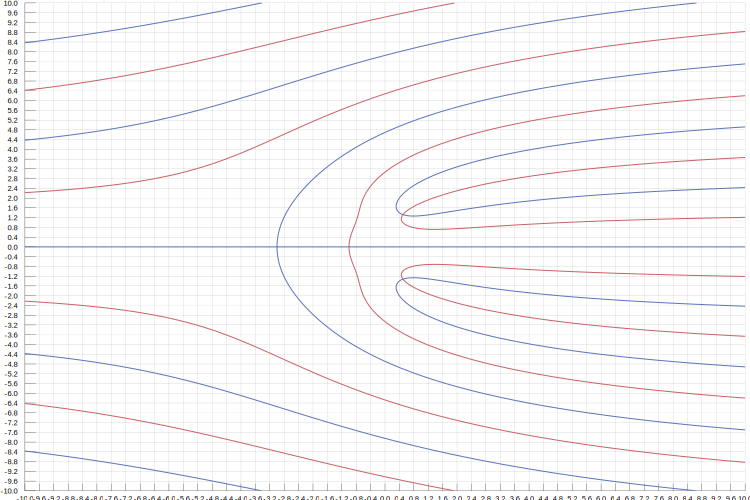

In [149]:
delta = (lambda^3+lambda+2)*e^(lambda)
separatedDelta = separate_real_imaginary(delta)
plot_levelCurves(separatedDelta; width = 3000, height = 2000)

In [150]:
# approximate_root(separatedDelta; xRange = (0.4, 0.8), yRange = (1.2, 1.6))

# The Fokas Transform pair

Implement the transform pair (2.15a), (2.15b) on page 10 of "Evolution PDEs and augmented eigenfunctions. Finite interval."

Transform pair:
\begin{alignat*}{2}
F_\lambda: f(x)&\mapsto F(\lambda):\quad F_\lambda(f) &= 
\begin{cases}
F_\lambda^+(f),&\quad\mbox{if $\lambda\in \Gamma_0^+\cup \Gamma_a^+$}\\
F_\lambda^-(f),&\quad\mbox{if $\lambda\in \Gamma_0^-\cup \Gamma_a^-$}\\
\end{cases}\\
f_x: F(\lambda)&\mapsto f(x):\quad f_x(F) &= \int_\Gamma e^{i\lambda x}F(\lambda)\,d\lambda,\quad x\in [0,1].
\end{alignat*}

## `get_input(a, S, f, B)`

Define $n$ linearly independent boundary forms $\{B_j: C\to\mathbb{C}\mid j\in\{1,2,\ldots,n\}\}$
\begin{align*}
B_j\phi &= \sum_{k=0}^{n-1} \left(b_{jk}\phi^{(k)}(0) + \beta_{jk}\phi^{(k)}(1)\right),\quad j\in \{1,2,\ldots, n\}.
\end{align*}
Define 
\begin{align*}
\Phi &= \{\phi\in C: B_j\phi = 0\,\forall j \in \{1,2,\ldots, n\}\}.
\end{align*}
Let $S:\Phi\to C$ be the linear differential operator 
$$S\phi(x) = (-i)^n \phi^{(n)}(x).$$

Let $a\in\mathbb{C}$ be a constant.

Given the IBVP
\begin{alignat*}{2}
(\partial_t + aS)q(x,t) &= 0,\quad&(x,t)\in (0,1)\times (0,T)\\
q(x,0) = f(x)&\in\Phi,\quad &x\in [0,1]\\
q(\cdot, t) &\in\Phi,\quad &t\in [0,T],
\end{alignat*}
constructs the algorithm inputs `LinearDifferentialOperator` $L$, `VectorBoundaryForm` $U$, and function $f(x)$.

In [151]:
function get_input(a::Number, S::LinearDifferentialOperator, f::Union{Function, Number}, B::VectorBoundaryForm)
#     pFunctions = [mult_func(a, func) for func in S.pFunctions]
#     (a,b) = (a*S.a, a*S.b)
#     symPFunctions = [a*symFunc for symFunc in (S.symL).symPFunctions]
#     t = (S.symL).t
#     symL = SymLinearDifferentialOperator(symPFunctions, (a,b), t)
#     L = LinearDifferentialOperator(pFunctions, (a,b), symL)
    L = S
    U = B
    return (L, U, f)
end

get_input (generic function with 1 method)

**Parameters**
* `a`: `Number`
    * Complex number such that if $n$ is odd then $a=\pm i$ and if $n$ is even then $\Re(a)\geq 0$.
* `S`: `LinearDifferentialOperator`
    * Linear differential operator in the spatial variable $x$.
* `f`: `Function` or `Number`
    * Initial data $q(x,0)$ that satisfies the boundary conditions $\Phi$.
* `B`: `VectorBoundaryForm`
    * Vector boundary form associated with two matrices $b$ and $\beta$ whose $jk$-entries are $b_{jk}$ and $\beta_{jk}$, respectively.

**Returns**
* `get_input`: `Tuple{LinearDifferentialOperator, VectorBoundaryForm, Union{Function, Number}}`
    * Returns the objects `LinearDifferentialOperator` $L$, `VectorBoundaryForm` $U$, and function $f(x)$ used in the algorithm to construct the Fokas transform pairs.

**Example**

Suppose $n=2$. Then
$$S\phi(x)= (-i)^2 \phi^{(2)}(x) = \phi^{(2)}.$$
Suppose $a=e^{i\theta}$ for $\theta\in [-\frac{\pi}{2}, \frac{\pi}{2}]$. 

For $\beta_0, \beta_1\in\hat{\mathbb{C}}$ ($\mathbb{C}$ including $0$ and $\infty$), consider the following boundary conditions $\Phi$:
\begin{align*}
\varphi(0) + \beta_0\varphi(1) &= 0\\
\varphi'(0) + \beta_1\varphi'(1) &= 0.
\end{align*}

We note that in complete form,
* $S$ is given by
$$S\phi = p_0 \phi^{(2)} + p_1 \phi^{(1)} + p_2 \phi^{(0)}$$
where $p_0=1$, $p_1=p_2=0$.
* $\Phi$ is given by 
\begin{align*}
1\cdot \varphi(0) + \beta_0\cdot \varphi(1) + 0\cdot \varphi^{(1)}(0) + 0\cdot \varphi^{(1)}(1) &= 0\\
0\cdot \varphi(0) + 0\cdot \varphi(1) + 1\cdot \varphi^{(1)}(0) + \beta_1\cdot \varphi^{(1)}(1) &= 0.
\end{align*}
Thus,
$$b = \begin{bmatrix}1&0\\0&1\end{bmatrix},\quad \beta = \begin{bmatrix}\beta_0&0\\0&\beta_1\end{bmatrix}.$$

In [152]:
beta0 = 1
beta1 = 1+im
theta = 0
a = e^(im*theta)
f(x)=0

f (generic function with 1 method)

In [153]:
t = symbols("t")
symPFunctions = [1 0 0]
interval = (0,1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
S = get_L(symL)
b = [1 0; 0 1]
beta = [beta0 0; 0 beta1]
B = VectorBoundaryForm(b, beta)
get_input(a, S, f, B)

(LinearDifferentialOperator([1 0 0], (0, 1), SymLinearDifferentialOperator([1 0 0], (0, 1), t)), VectorBoundaryForm([1 0; 0 1], Complex{Int64}[1+0im 0+0im; 0+0im 1+1im]), f)

Now, for $b_0, b_1\in\hat{\mathbb{C}}$, consider the following boundary conditions $\Phi$:
\begin{align*}
\varphi(0) + b_0\varphi'(0) &= 0\\
\varphi(1) + b_1\varphi'(1) &= 0.
\end{align*}
We note that in complete form,
* $\Phi$ is given by 
\begin{align*}
1\cdot \varphi(0) + 0\cdot \varphi(1) + b_0\cdot \varphi^{(1)}(0) + 0\cdot \varphi^{(1)}(1) &= 0\\
0\cdot \varphi(0) + 1\cdot \varphi(1) + 0\cdot \varphi^{(1)}(0) + b_1\cdot \varphi^{(1)}(1) &= 0.
\end{align*}
Thus,
$$b = \begin{bmatrix}1&b_0\\ 0&0\end{bmatrix},\quad \beta = \begin{bmatrix}0&0\\ 1&b_1\end{bmatrix}.$$

In [154]:
b0 = 1
b1 = 1+im
theta = 0
a = e^(im*theta)
f(x)=0

f (generic function with 1 method)

In [155]:
b = [1 b0; 0 0]
beta = [0 0; 1 b1]
B = VectorBoundaryForm(b, beta)
get_input(a, S, f, B)

(LinearDifferentialOperator([1 0 0], (0, 1), SymLinearDifferentialOperator([1 0 0], (0, 1), t)), VectorBoundaryForm([1 1; 0 0], Complex{Int64}[0+0im 0+0im; 1+0im 1+1im]), f)

Now suppose $n=3$. Then 
$$S\phi(x) = (-i)^3 \phi^{(3)}(x) = i\phi^{(3)}.$$
Suppose $a=\pm i$.

For $\beta_0, \beta_1, \beta_2\in\hat{\mathbb{C}}$ ($\mathbb{C}$ including $0$ and $\infty$), consider the following boundary conditions $\Phi$:
\begin{align*}
\phi(0) + \beta_0\phi(1) &= 0\\
\phi^{(1)}(0) + \beta_1\phi^{(1)}(1) &= 0\\
\phi^{(2)}(0) + \beta_2\phi^{(2)}(1) &= 0.
\end{align*}

We note that in complete form,
* $S$ is given by
$$S\phi = p_0 \phi^{(3)} + p_1 \phi^{(2)} + p_2 \phi^{(1)} + p_3\phi$$
where $p_0=i$, $p_1=p_2=p_3=0$.
* $\Phi$ is given by 
\begin{align*}
1\cdot \phi(0) + \beta_0\cdot \phi(1) + 0\cdot \phi^{(1)}(0) + 0\cdot\phi^{(1)}(1) + 0\cdot \phi^{(2)}(0) + 0\cdot\phi^{(2)}(1) &= 0\\
0\cdot \phi(0) + 0\cdot \phi(1) + 1\cdot \phi^{(1)}(0) + \beta_1\cdot \phi^{(1)}(1) + 0\cdot \phi^{(2)}(0) + 0\cdot\phi^{(2)}(1) &= 0\\
0\cdot \phi(0) + 0\cdot \phi(1) + 0\cdot \phi^{(1)}(0) + 0\cdot \phi^{(1)}(1) + 1\cdot \phi^{(2)}(0) + \beta_2\cdot \phi^{(2)}(1) &= 0.
\end{align*}
Thus,
$$b = \begin{bmatrix}1&0&0\\0&1&0\\ 0&0&1\end{bmatrix},\quad \beta = \begin{bmatrix}\beta_0&0&0\\0&\beta_1&0\\ 0&0&\beta_2\end{bmatrix}.$$

In [156]:
beta0 = 1
beta1 = 1+im
beta2 = 2
theta = 0
a = im
f(x)=0

f (generic function with 1 method)

In [157]:
t = symbols("t")
symPFunctions = [im 0 0 0]
interval = (0,1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
S = get_L(symL)
b = [1 0 0; 0 1 0; 0 0 1]
beta = [beta0 0 0; 0 beta1 0; 0 0 beta2]
B = VectorBoundaryForm(b, beta)
get_input(a, S, f, B)

(LinearDifferentialOperator(Complex{Int64}[0+1im 0+0im 0+0im 0+0im], (0, 1), SymLinearDifferentialOperator(Complex{Int64}[0+1im 0+0im 0+0im 0+0im], (0, 1), t)), VectorBoundaryForm([1 0 0; 0 1 0; 0 0 1], Complex{Int64}[1+0im 0+0im 0+0im; 0+0im 1+1im 0+0im; 0+0im 0+0im 2+0im]), f)

Now, for $b_0\in\hat{\mathbb{C}}$, consider the following boundary conditions $\Phi$:
\begin{align*}
\varphi(0) &= 0\\
\varphi(1) &= 1\\
\varphi^{(1)}(0) + b_0\varphi^{(1)}(1) &= 0.
\end{align*}
We note that in complete form,
* $\Phi$ is given by 
\begin{align*}
1\cdot \varphi(0) + 0\cdot \varphi(1) + 0\cdot \varphi^{(1)}(0) + 0\cdot \varphi^{(1)}(1) +  0\cdot \varphi^{(2)}(0) + 0\cdot \varphi^{(2)}(1)&= 0\\
0\cdot \varphi(0) + 1\cdot \varphi(1) + 0\cdot \varphi^{(1)}(0) + 0\cdot \varphi^{(1)}(1) +  0\cdot \varphi^{(2)}(0) + 0\cdot \varphi^{(2)}(1)&= 0\\
0\cdot \varphi(0) + 0\cdot \varphi(1) + 1\cdot \varphi^{(1)}(0) + b_0\cdot \varphi^{(1)}(1) +  0\cdot \varphi^{(2)}(0) + 0\cdot \varphi^{(2)}(1)&= 0
\end{align*}
Thus,
$$b = \begin{bmatrix}1&0&0\\ 0&0&0\\ 0&1&0\end{bmatrix},\quad \beta = \begin{bmatrix}0&0&0\\ 1&0&0\\ 0&b_0&0\end{bmatrix}.$$

In [158]:
b0 = im
b = [1 0 0; 0 0 0; 0 1 0]
beta = [0 0 0; 1 0 0; 0 b0 0]
B = VectorBoundaryForm(b, beta)
get_input(a, S, f, B)

(LinearDifferentialOperator(Complex{Int64}[0+1im 0+0im 0+0im 0+0im], (0, 1), SymLinearDifferentialOperator(Complex{Int64}[0+1im 0+0im 0+0im 0+0im], (0, 1), t)), VectorBoundaryForm([1 0 0; 0 0 0; 0 1 0], Complex{Int64}[0+0im 0+0im 0+0im; 1+0im 0+0im 0+0im; 0+0im 0+1im 0+0im]), f)

## `get_MPlusMinus(adjointU; symbolic)`

Let $\alpha=e^{2\pi i/n}$; given adjoint vector boundary form associated with two matrices $b^\star$, $\beta^\star$, computes matrices $M^+(\lambda)$, $M^-(\lambda)$ given by
\begin{align*}
M^+_{kj}(\lambda) &= \sum_{r=0}^{n-1}(-i\alpha^{k-1}\lambda)^rb^\star_{jr}\\
M^-_{kj}(\lambda) &= \sum_{r=0}^{n-1}(-i\alpha^{k-1}\lambda)^r\beta^\star_{jr}
\end{align*}
as functions of $\lambda$ (for fixed $b^\star$, $\beta^\star$) or their symbolic expressions.

In [159]:
function get_MPlusMinus(adjointU::VectorBoundaryForm; symbolic = false)
    # these are numeric matrices
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    if symbolic
        alpha = e^(2*PI*im/n)
        # return MPlus and MMinus as symbolic expressions with (the global variable) lambda as free variable
        MPlusMat = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                sumPlus = 0
                for r = 0:(n-1)
                    summandPlus = (-im*alpha^(k-1)*lambda)^r * bStar[j,r+1]
                    summandPlus = expand(summandPlus)
                    sumPlus += summandPlus
                end
                sumPlus = simplify(prettyPrint(sumPlus))
                MPlusMat[k,j] = sumPlus
            end
        end
        MPlusSym = MPlusMat
        MMinusMat = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                sumMinus = 0
                for r = 0:(n-1)
                    summandMinus = (-im*alpha^(k-1)*lambda)^r * betaStar[j,r+1]
                    summandMinus = expand(summandMinus)
                    sumMinus += summandMinus
                end
                sumMinus = simplify(prettyPrint(sumMinus))
                MMinusMat[k,j] = sumMinus
            end
        end
        MMinusSym = MMinusMat
        return (MPlusSym, MMinusSym)
    else
        alpha = e^(2pi*im/n)
        # if not symbolic, return MPlus and MMinus as functions of lambda
        function MPlus(lambda::Number)
            MPlusMat = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    sumPlus = 0
                    for r = 0:(n-1)
                        summandPlus = (-im*alpha^(k-1)*lambda)^r * bStar[j,r+1]
                        sumPlus += summandPlus
                    end
                    MPlusMat[k,j] = sumPlus
                end
            end
            return MPlusMat
        end
        function MMinus(lambda::Number)
            MMinusMat = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    sumMinus = 0
                    for r = 0:(n-1)
                        summandMinus = (-im*alpha^(k-1)*lambda)^r * betaStar[j,r+1]
                        sumMinus += summandMinus
                    end
                    MMinusMat[k,j] = sumMinus
                end
            end
            return MMinusMat
        end
    end
    return (MPlus, MMinus)
end

get_MPlusMinus (generic function with 1 method)

**Parameters**
* `adjointU`: `VectorBoundaryForm`
    * Output of `get_adjointU()`.
* `symbolic`: `Bool`
    * Boolean indicating whether the output is symbolic.

**Returns**
* `get_MPlusMinus`: `Function` or `SymPy.Sym`
    * Returns $M^+(\lambda)$, $M^-(\lambda)$ as functions if `symbolic = false` and as symbolic expressions if `symbolic = true`.

**Example**
<!-- * $$b^\star = \begin{bmatrix}-1&0\\0&0\end{bmatrix},\quad \beta^\star = \begin{bmatrix}0&0\\2&-1\end{bmatrix}.$$
Then
\begin{align*}
M^+_{11} &= \sum_{r=0}^{2-1}(-i\left(e^{2\pi i/2}\right)^{1-1}\lambda)^rb^\star_{1(r+1)} = (-i\lambda)^0\cdot b^\star_{11} +(-i\lambda)\cdot b^\star_{12} = -1 + 0 = -1\\
M^+_{12} &= \sum_{r=0}^{2-1}(-i\left(e^{2\pi i/2}\right)^{1-1}\lambda)^rb^\star_{2(r+1)} = (-i\lambda)^0\cdot b^\star_{21} + (-i\lambda)\cdot b^\star_{22} = 0 + 0 = 0\\
M^+_{21} &= \sum_{r=0}^{2-1}(-i\left(e^{2\pi i/2}\right)^{2-1}\lambda)^rb^\star_{1(r+1)} = (-ie^{\pi i}\lambda)^0\cdot b^\star_{11} + (-ie^{\pi i}\lambda)\cdot b^\star_{12} = -1 + 0 = -1\\
M^+_{22} &= \sum_{r=0}^{2-1}(-i\left(e^{2\pi i/2}\right)^{2-1}\lambda)^rb^\star_{2(r+1)} = (-ie^{\pi i}\lambda)^0 b^\star_{21} + (-ie^{\pi i}\lambda)\cdot b^\star_{22} = 0 + 0 = 0,
\end{align*}
and
\begin{align*}
M^-_{11} &= \sum_{r=0}^{2-1}(-i\left(e^{2\pi i/2}\right)^{1-1}\lambda)^r\beta^\star_{1(r+1)} = (-i\lambda)^0\cdot \beta^\star_{11} + (-i\lambda)\cdot \beta^\star_{12} = 0 + 0 = 0\\
M^-_{12} &= \sum_{r=0}^{2-1}(-i\left(e^{2\pi i/2}\right)^{1-1}\lambda)^r\beta^\star_{2(r+1)} = (-i\lambda)^0\cdot \beta^\star_{21} + (-i\lambda)\cdot \beta^\star_{22} = 2 + (-i\lambda)\cdot (-1) = 2+i\lambda\\
M^-_{21} &= \sum_{r=0}^{2-1}(-i\left(e^{2\pi i/2}\right)^{2-1}\lambda)^r\beta^\star_{1(r+1)} = (-ie^{\pi i}\lambda)^0\cdot\beta^\star_{11} + (-ie^{\pi i}\lambda)\cdot \beta^\star_{12} = 0 + 0 = 0\\
M^-_{22} &= \sum_{r=0}^{2-1}(-i\left(e^{2\pi i/2}\right)^{2-1}\lambda)^r\beta^\star_{2(r+1)} = (-ie^{\pi i}\lambda)^0\cdot \beta^\star_{21} + (-ie^{\pi i}\lambda)\cdot \beta^\star_{22} = 2 - i\lambda.
\end{align*} -->

In [160]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
L = get_L(symL)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)

adjointU = get_adjointU(L, U)

VectorBoundaryForm(Complex[-1.0-0.0im 0.0-0.0im; 0.0-0.0im 0.0-0.0im], Complex[0.0-0.0im 0.0-0.0im; 2.0-0.0im -1.0-0.0im])

In [161]:
get_MPlusMinus(adjointU; symbolic = true)

(SymPy.Sym[-1 0; -1 0], SymPy.Sym[0 I*lambda + 2; 0 -I*lambda + 2])

In [162]:
get_MPlusMinus(adjointU; symbolic = false)

(MPlus, MMinus)

## `get_M(adjointU; symbolic)`

Computes $M$ given by
$$M_{kj}(\lambda) = M^+_{kj}(\lambda) + M^-_{kj}(\lambda)e^{-i\alpha^{k-1}\lambda}$$
as a function of $\lambda$ or its symbolic expression.

In [163]:
function get_M(adjointU::VectorBoundaryForm; symbolic = false)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    if symbolic
        alpha = e^(2*PI*im/n)
        # return M as a symbolic expression with (the global variable) lambda as free variable
        (MPlusSym, MMinusSym) = get_MPlusMinus(adjointU; symbolic = true)
        MLambdaSym = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                MLambdaSym[k,j] = simplify(prettyPrint(MPlusSym[k,j] + MMinusSym[k,j] * e^(-im*alpha^(k-1)*lambda)))
            end
        end
        MSym = MLambdaSym
        return MSym
    else
        alpha = e^(2pi*im/n)
        function M(lambda::Number)
            (MPlus, MMinus) = get_MPlusMinus(adjointU)
            MPlusLambda, MMinusLambda = MPlus(lambda), MMinus(lambda)
            MLambda = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    MLambda[k,j] = MPlusLambda[k,j] + MMinusLambda[k,j] * e^(-im*alpha^(k-1)*lambda)
                end
            end
            return MLambda
        end
        return M 
    end
end

get_M (generic function with 1 method)

**Parameters**
* `adjointU`: `VectorBoundaryForm`
    * Output of `get_adjointU()`.
* `symbolic`: `Bool`
    * Boolean indicating whether the output is symbolic.

**Returns**
* `get_M`: `Function` or `SymPy.Sym`
    * Returns $M(\lambda)$ as function if `symbolic = false` and as symbolic expression if `symbolic = true`.

**Example**

In [164]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
L = get_L(symL)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)

adjointU = get_adjointU(L, U)

VectorBoundaryForm(Complex[-1.0-0.0im 0.0-0.0im; 0.0-0.0im 0.0-0.0im], Complex[0.0-0.0im 0.0-0.0im; 2.0-0.0im -1.0-0.0im])

In [165]:
get_M(adjointU; symbolic = true)

2×2 Array{SymPy.Sym,2}:
 -1  (I*lambda + 2)*exp(-I*lambda)
 -1  (-I*lambda + 2)*exp(I*lambda)

In [166]:
prettyPrint(get_M(adjointU; symbolic = false)(1))

2×2 Array{SymPy.Sym,2}:
 -1  1.92 - 1.14*I
 -1  1.92 + 1.14*I

## `get_delta(adjointU; symbolic)`

Computes $\Delta := \det(M)$ as a function of $\lambda$ (for fixed `adjointU`) or its symbolic expression.

In [167]:
function get_delta(adjointU::VectorBoundaryForm; symbolic = false)
    if symbolic
        MSym = get_M(adjointU; symbolic = true)
        deltaSym = simplify(SymPy.det(MSym))
        return deltaSym
    else
       function delta(lambda::Number)
            M = get_M(adjointU)
            MLambda = convert(Array{Complex}, M(lambda))
            return det(MLambda)
        end
        return delta 
    end
end

get_delta (generic function with 1 method)

**Parameters**
* `adjointU`: `VectorBoundaryForm`
    * Output of `get_adjointU()`.
* `symbolic`: `Bool`
    * Boolean indicating whether the output is symbolic.

**Returns**
* `get_delta`: `Function` or `SymPy.Sym`
    * Returns $\Delta(\lambda)$ as function if `symbolic = false` and as symbolic expression if `symbolic = true`.

**Example**

In [168]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
L = get_L(symL)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)

adjointU = get_adjointU(L, U)

VectorBoundaryForm(Complex[-1.0-0.0im 0.0-0.0im; 0.0-0.0im 0.0-0.0im], Complex[0.0-0.0im 0.0-0.0im; 2.0-0.0im -1.0-0.0im])

In [169]:
get_delta(adjointU; symbolic = true)

/                           2*I*lambda    \  -I*lambda
\I*lambda + (I*lambda - 2)*e           + 2/*e         

In [170]:
get_delta(adjointU; symbolic = false)

(::delta) (generic function with 1 method)

## `get_Xlj(adjointU, l, j; symbolic)`

Gets $X_{lj}$, which is the $(n-1)\times (n-1)$ submatrix of $M(\lambda)$ whose $11$-entry is the $(l+1)(j+1)$-entry of $M(\lambda)$, as a function of $\lambda$ (for fixed `adjointU`, $M$, $l$, $j$), or its symbolic expression.

In [171]:
function get_Xlj(adjointU::VectorBoundaryForm, l::Number, j::Number; symbolic = false)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    if symbolic
        MSym = get_M(adjointU; symbolic = true)
        MBlockSym = [MSym MSym; MSym MSym]
        XljSym = MBlockSym[(l+1):(l+1+n-2), (j+1):(j+1+n-2)]
        return XljSym
    else
        M = get_M(adjointU; symbolic = false)
        function Xlj(lambda::Number)
            MLambda = M(lambda)
            MLambdaBlock = [MLambda MLambda; MLambda MLambda]
            XljLambda = MLambdaBlock[(l+1):(l+1+n-2), (j+1):(j+1+n-2)]
            return XljLambda
        end
        return Xlj 
    end
end

get_Xlj (generic function with 1 method)

**Parameters**
* `adjointU`: `VectorBoundaryForm`
    * Output of `get_adjointU()`.
* `l`, `j`: `Int`
    * Indices specifying the submatrix of $M$ that is $X_{lj}$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.

**Returns**
* `get_Xlj`: `Array` of `Function` or `SymPy.Sym`
    * Returns $X_{lj}(\delta)$ as a matrix of functions if `symbolic = false` and as symbolic expressions if `symbolic = true`.

**Example**

In [172]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
L = get_L(symL)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)

adjointU = get_adjointU(L, U)

l, j = 1, 1
get_Xlj(adjointU, l, j; symbolic = true)

1×1 Array{SymPy.Sym,2}:
 (-I*lambda + 2)*exp(I*lambda)

In [173]:
get_Xlj(adjointU, l, j; symbolic = false)

(::Xlj) (generic function with 1 method)

## `get_ChebyshevIntegral(l, f; symbolic, lambda, alpha)`

Computes
$$\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx$$
by approximating $f(x)$ using Chebyshev polynomials and obtaining an explicit expression for the integral.

<!--
Since the Chebyshev coefficients are given on $[-1,1]$, we need to shift the interval via some function $g(x)$ such that
$$f(x) = \sum_{n=0}^N b_n T_n(g(x)).$$
Define $g(x):[0,1]\to [-1,1]$ by $g(x)=2x-1$. We want to compute
$$\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx.$$
With the change of variable $t=g(x)=2x-1$, we have $x=g^{-1}(t)=\frac{t+1}{2}$. Writing $c=\frac{\alpha^{l-1}\lambda}{2}$, we have
\begin{align*}
    \int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx &= \int_0^1 e^{-i2c\frac{t+1}{2}}f(\frac{t+1}{2})\,d(\frac{t+1}{2})\\
    &= \int_{-1}^1 e^{-ict}e^{-ic}f(\frac{t+1}{2})\frac{1}{2}\,dt\\
    &= \frac{1}{2e^{ic}}\int_{-1}^1 e^{-ict} f(\frac{t+1}{2})\,dt\\
    &= \frac{1}{2e^{ic}}\int_{-1}^1 e^{-ict} q(t)\,dt,
\end{align*}
where $q(t) := f\circ g^{-1}(t)$.

In summary,
$$f(x) = f\circ g^{-1}(g(x)) = q(g(x)) = q(t) = \sum_{n=0}^N b_n T_n(t) = \sum_{n=0}^N b_n T_n(g(x)),$$
and
\begin{align*}
    \int_{-1}^1 e^{-ic t}q(t)\,dt &= \sum_{n=0}^N b_n \int_{-1}^1 e^{-ic t} \cos(n\cdot\cos^{-1}(t))\,dt\\
    &= \sum_{n=0}^N b_n \tilde{T}_n(\frac{\alpha^{l-1}\lambda}{2}),
\end{align*}
where 
\begin{alignat*}{2}
    \tilde{T}_n(c) = \int_0^\pi e^{-ic\cos\theta}\cos(n\theta)\sin\theta\,d\theta &= 
    \begin{cases}
        2 &\quad\mbox{if $n=0$}\\
        0 &\quad\mbox{if $n=1$}\\
        \frac{(-1)^{n+1}-1}{n^2-1} &\quad\mbox{if $n\geq 2$}
    \end{cases},
    &\quad\mbox{if $c=0$}\\
    &= \frac{1}{ic}\left(nK_n(-ic) + (-1)^n e^{ic} - e^{-ic}\right)&\quad\mbox{if $c\neq 0$},
\end{alignat*}
where 
\begin{align*}
    K_0(z) &= 0\\
    K_1(z) &= \frac{e^z-e^{-z}}{z}\\
    K_{n}(z) &= K_{n-2}(z) + 2\left(\frac{e^z}{z} + (-1)^{n}\frac{e^{-z}}{z} - \frac{n-1}{z}K_{n-1}(z)\right),\quad n\geq 2.
\end{align*} -->

### `get_Kn(n; symbolic, z)`

Computes $K_n(z)$ given by 
\begin{align*}
    K_0(z) &= 0\\
    K_1(z) &= \frac{e^z-e^{-z}}{z}\\
    K_{n}(z) &= K_{n-2}(z) + 2\left(\frac{e^z}{z} + (-1)^{n}\frac{e^{-z}}{z} - \frac{n-1}{z}K_{n-1}(z)\right),\quad n\geq 2
\end{align*}
or its symbolic expression.

In [174]:
function get_Kn(n; symbolic = true, z = symbols("z"))
    if symbolic
        if n == 0
            expr = 0
        elseif n == 1
            expr = 1/z*(e^z-e^(-z))
        else
            expr = get_Kn(n-2; symbolic = true) + 2(e^z/z + (-1)^n*e^(-z)/z - (n-1)/z*get_Kn(n-1; symbolic = true, z = z))
        end
        expr = prettyPrint(expr)
        return expr
    else
        function Kn(z)
            if z == 0
                throw("z cannot be 0")
            end
            if n == 0
                result = 0
            elseif n == 1
                result = 1/z*(e^z-e^(-z))
            else
                result = get_Kn(n-2; symbolic = false)(z) + 2*(e^z/z + (-1)^n*e^(-z)/z - (n-1)/z*get_Kn(n-1; symbolic = false)(z))
            end
            return result
        end
        return Kn
    end
end

get_Kn (generic function with 1 method)

**Parameters**
* `n`: `Int`
    * $n$ in $K_n(z)$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.
* `z*`: `SymPy.Sym`
    * If `symbolic = true`, argument of $K_n(z)$. Default to `symbols("z")`.
    

**Returns**
* `get_Kn`: `SymPy.Sym` or `Function`
    * Returns $K_n(z)$ as a function if `symbolic = false` and as a symbolic expression if `symbolic = true`.

**Example**

In [175]:
get_Kn(2; symbolic = true)

   z      -z     / z    -z\
2*e    2*e     2*\e  - e  /
---- + ----- - ------------
 z       z           2     
                    z      

In [176]:
get_Kn(2; symbolic = false)

(::Kn) (generic function with 1 method)

### `get_ChebyshevTermIntegral(n; symbolic, c)`

Computes $\tilde{T}_n(c)$ given by 
\begin{alignat*}{2}
    \tilde{T}_n(c) = \int_0^\pi e^{-ic\cos\theta}\cos(n\theta)\sin\theta\,d\theta &= 
    \begin{cases}
        2 &\quad\mbox{if $n=0$}\\
        0 &\quad\mbox{if $n=1$}\\
        \frac{(-1)^{n+1}-1}{n^2-1} &\quad\mbox{if $n\geq 2$}
    \end{cases},
    &\quad\mbox{if $c=0$}\\
    &= \frac{1}{ic}\left(nK_n(-ic) + (-1)^n e^{ic} - e^{-ic}\right)&\quad\mbox{if $c\neq 0$}
\end{alignat*}
or its symbolic expression.

In [177]:
function get_ChebyshevTermIntegral(n::Int; symbolic = true, c = symbols("c"))
    if symbolic
        if c == 0
            if n == 0
                expr = 2
            elseif n == 1
                expr = 0
            else
                expr = ((-1)^(n+1)-1)/(n^2-1)
            end
        else
            expr = 1/(im*c)*(n*get_Kn(n; symbolic = true, z = (-im*c)) + (-1)^n*e^(im*c) - e^(-im*c))
        end
        expr = prettyPrint(expr)
        return expr
    else
        function TTilde(c)
            if c == 0
                if n == 0
                    result = 1
                elseif n == 1
                    result = 1/2
                else
                    result = ((-1)^(n+1)-1)/(n^2-1)
                end
            else
                result = 1/(im*c)*(n*get_Kn(n; symbolic = false)(-im*c) + (-1)^n*e^(im*c) - e^(-im*c))
            end
            return result
        end
        return TTilde
    end
end

get_ChebyshevTermIntegral (generic function with 1 method)

**Parameters**
* `n`: `Int`
    * $n$ in $\tilde{T}_n$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.
* `c*`: `SymPy.Sym`
    * If `symbolic = true`, argument of $\tilde{T}_n$. Default to `symbols("c")`.

**Returns**
* `get_ChebyshevTermintegral`: `Function` or `SymPy.Sym`
    * Returns $\tilde{T}_n(c)$ as function of $c$ if `symbolic = false` and as symbolic expression if `symbolic = true`.

**Example**

In [178]:
get_ChebyshevTermIntegral(2; symbolic = true)

   /                    I*c        -I*c     /   I*c    -I*c\\ 
   | I*c    -I*c   4*I*e      4*I*e       4*\- e    + e    /| 
-I*|e    - e     + -------- + --------- + ------------------| 
   |                  c           c                2        | 
   \                                              c         / 
--------------------------------------------------------------
                              c                               

In [179]:
get_ChebyshevTermIntegral(2; symbolic = false)

(::TTilde) (generic function with 1 method)

### `get_ChebyshevCoefficients(f)`

Obtains the coefficients in the Chebyshev approximation of $f$ on $[0,1]$. 

Note that the coefficients are obtained by shifting the interval $[0,1]$ to $[-1,1]$ and then back. That is, define $g:[0,1]\to [-1,1]$ by $g(x) = 2x-1$. For $t\in [-1,1]$, define $q(t)=f\circ g^{-1}(t) = f(\frac{t+1}{2}) =: f(x)$ for $x\in [0,1]$. Then the returned coefficients are $\{b_0,\ldots, b_N\}$ in
$$f(x) = f\circ g^{-1}(g(x)) = q(g(x)) = q(t) = \sum_{n=0}^N b_n T_n(t) = \sum_{n=0}^N b_n T_n(g(x)) = \sum_{n=0}^N b_n T_n(2x-1)$$
instead of $\{a_0,\ldots, a_N\}$ in
$$f(x) = \sum_{n=0}^N a_n T_n(x).$$

In [180]:
function get_ChebyshevCoefficients(f::Union{Function,Number})
    fCheb = ApproxFun.Fun(f, 0..1) # Approximate f on [0,1] using chebyshev polynomials
    chebCoefficients = ApproxFun.coefficients(fCheb) # get coefficients of the Chebyshev polynomial
    return chebCoefficients
end

get_ChebyshevCoefficients (generic function with 1 method)

**Parameters**
* `f`: `Function` or `Number`
    * Function whose Chebyshev coefficients are to be returned.

**Returns**
* `get_ChebyshevCoefficients`: `Array` of `Number`
    * Returns $\{b_0,\ldots, b_N\}$.

**Example**

In [181]:
f(x) = x^2+1
get_ChebyshevCoefficients(f)

3-element Array{Float64,1}:
 1.375
 0.5  
 0.125

### `get_ChebyshevIntegral(l, f; symbolic, lambda, alpha)`

Computes
$$\int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx$$
by computing
\begin{align*}
    \frac{1}{2e^{ic}}\int_{-1}^1 e^{-ict} q(t)\,dt = \int_0^1 e^{-i\alpha^{l-1}\lambda x}f(x)\,dx
\end{align*}
where $c=\frac{\alpha^{l-1}\lambda}{2}$, $q(t) := f\circ g^{-1}(t)$,
and
\begin{align*}
    \int_{-1}^1 e^{-ic t}q(t)\,dt &= \int_{-1}^1 e^{-ic t} \sum_{n=0}^N b_n T_n(t)\,dt\\
    &= \sum_{n=0}^N b_n \int_{-1}^1 e^{-ic t} T_n(t)\,dt\\
    &= \sum_{n=0}^N b_n \int_{-1}^1 e^{-ic t} \cos(n\cdot\cos^{-1}(t))\,dt\\
    &= \sum_{n=0}^N b_n \tilde{T}_n(c).
\end{align*}

In [182]:
function get_ChebyshevIntegral(l::Number, f::Union{Function, Number}; symbolic = false, lambda = nothing, alpha = nothing)
    fChebCoeffs = get_ChebyshevCoefficients(f)
    if symbolic
        c = alpha^(l-1)*lambda/2
        integralSym = 0
        for m = 1:length(fChebCoeffs)
            integralSym += fChebCoeffs[m] * get_ChebyshevTermIntegral(m-1; symbolic = true, c = c)
        end
        integralSym = integralSym/(2*e^(im*c))
        integralSym = prettyPrint(integralSym)
        integralSym = simplify(integralSym)
        return integralSym
    else
        if isa(lambda, Void) || isa(alpha, Void)
            throw("lambda, alpha required")
        else
            c = alpha^(l-1)*lambda/2
            integral = 0
            for m = 1:length(fChebCoeffs)
                integral += fChebCoeffs[m] * get_ChebyshevTermIntegral(m-1; symbolic = false)(c)
            end
            integral = integral/(2*e^(im*c))
            return integral
        end
    end
end

get_ChebyshevIntegral (generic function with 1 method)

**Parameters**
* `l`: `Int`
    * $l$ in the integral.
* `f`: `Function` or `Number`
    * $f(x)$ in the integral.
* `symbolic*` : `Bool`
    * Boolean indicating whether the output is symbolic.
* `lambda*`: `SymPy.Sym` or `Number`
    * $\lambda$ in the integral. Symbolic if `symbolic = true` and numeric if `symbolic = false`. Default to `symbols("lambda")`.
* `alpha*`: `SymPy.Sym` or `Number`
    * $\alpha$ in the integral. Default to `symbols("alpha")`.

**Returns**
* `get_ChebyshevIntegral` : `Function` or `SymPy.Sym`
    * Returns the integral as a symbolic expression if `symbolic = true` and as a function of $\lambda$ if `symbolic = false`.

**Example**

In [183]:
alpha = e^(2pi*im/1)
l = 2
f(x)=x^2+1
# Keep lambda as free variable
lambda = symbols("lambda")
prettyPrint(get_ChebyshevIntegral(l, f; symbolic = true, lambda = lambda, alpha = alpha))

                -I*lambda      -I*lambda                  -I*lambda
    I      2*I*e            2*e              2*I     2*I*e         
- ------ + -------------- + ------------ + ------- - --------------
  lambda       lambda               2            3            3    
                              lambda       lambda       lambda     

In [184]:
lambda = 1+im
get_ChebyshevIntegral(l, f; symbolic = false, lambda = lambda, alpha = alpha)

1.878024613547363 - 1.4093306736314783im

In [185]:
# Directly compute the integral
g(x) = e^(-im*alpha^(l-1)*lambda*x)
quadgk(mult_func(g,f), 0, 1)[1]

1.8780246135473633 - 1.4093306736314786im

## `get_FPlusMinusLambda(adjointU; symbolic, lambda)`

Gets $F^+_\lambda$, $F^-_\lambda$ given by 
\begin{align*}
    F^+_\lambda(f) &= \frac{1}{2\pi \Delta(\lambda)} \sum_{\ell=1}^n\sum_{j=1}(-1)^{(n-1)(\ell+j)}\det X^{lj}(\lambda)M^+_{1j}(\lambda)\int_0^1 e^{-i\alpha^{\ell-1}\lambda x}f(x)\,dx,\\
    F^-_\lambda(f) &= \frac{-e^{-i\lambda}}{2\pi \Delta(\lambda)} \sum_{\ell=1}^n\sum_{j=1}(-1)^{(n-1)(\ell+j)}\det X^{lj}(\lambda)M^-_{1j}(\lambda)\int_0^1 e^{-i\alpha^{\ell-1}\lambda x}f(x)\,dx.
\end{align*}
as functions of $f$ or their symbolic expressions.

In [186]:
function get_FPlusMinusLambda(adjointU::VectorBoundaryForm; symbolic = false, lambda = nothing)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    if symbolic
        alpha = e^(2*PI*im/n)
        lambda = symbols("lambda")
        (MPlusSym, MMinusSym) = get_MPlusMinus(adjointU; symbolic = true)
        deltaSym = get_delta(adjointU; symbolic = true)
        function FPlusSym(f::Union{Function, Number})
            sumPlusSym = 0
            for l = 1:n
                summandPlusSym = 0
                for j = 1:n
                    XljSym = get_Xlj(adjointU, l, j; symbolic = true)
                    integralSym = get_ChebyshevIntegral(l, f; symbolic = true, lambda = lambda, alpha = alpha)
                    summandPlusSym = summandPlusSym += (-1)^((n-1)*(l+j)) * SymPy.det(XljSym) * MPlusSym[1,j] * integralSym
                end
                sumPlusSym += summandPlusSym
            end
            return 1/(2*PI*deltaSym)*sumPlusSym
        end
        function FMinusSym(f::Union{Function, Number})
            sumMinusSym = 0
            for l = 1:n
                summandMinusSym = 0
                for j = 1:n
                    XljSym = get_Xlj(adjointU, l, j; symbolic = true)
                    c = alpha^(l-1)*lambda/2
                    integralSym = get_ChebyshevIntegral(l, f; symbolic = true, lambda = lambda, alpha = alpha)
                    summandMinusSym = summandMinusSym += (-1)^((n-1)*(l+j)) * SymPy.det(XljSym) * MMinusSym[1,j] * integralSym
                end
                sumMinusSym += summandMinusSym
            end
            return 1/(2*PI*deltaSym)*sumMinusSym
        end
        return (FPlusSym, FMinusSym)
    else
        alpha = e^(2pi*im/n)
        if isa(lambda, Void)
            throw("lambda required")
        end
        (MPlus, MMinus) = get_MPlusMinus(adjointU; symbolic = false)
        MPlusLambda, MMinusLambda = MPlus(lambda), MMinus(lambda)
        M = get_M(adjointU; symbolic = false)
        MLambda = convert(Array{Complex}, M(lambda))
        deltaLambda = det(MLambda) # or deltaLambda = (get_delta(adjointU))(lambda)
        function FPlusLambda(f::Union{Function, Number})
            sumPlus = 0
            for l = 1:n
                summandPlus = 0
                for j = 1:n
                    Xlj = get_Xlj(adjointU, l, j; symbolic = false)
                    XljLambda = convert(Array{Complex}, Xlj(lambda))
                    integral = get_ChebyshevIntegral(l, f; symbolic = false, lambda = lambda, alpha = alpha)
                    summandPlus = summandPlus += (-1)^((n-1)*(l+j)) * det(XljLambda) * MPlusLambda[1,j] * integral
                end
                sumPlus += summandPlus
            end
            return 1/(2pi*deltaLambda)*sumPlus
        end
        function FMinusLambda(f::Union{Function, Number})
            sumMinus = 0
            for l = 1:n
                summandMinus = 0
                for j = 1:n
                    Xlj = get_Xlj(adjointU, l, j)
                    XljLambda = convert(Array{Complex}, Xlj(lambda))
                    integral = get_ChebyshevIntegral(l, f; symbolic = false, lambda = lambda, alpha = alpha)
                    summandMinus = summandMinus += (-1)^((n-1)*(l+j)) * det(XljLambda) * MMinusLambda[1,j] * integral
                end
                sumMinus += summandMinus
            end
            return (-e^(-im*lambda))/(2pi*deltaLambda)*sumMinus
        end
        return (FPlusLambda, FMinusLambda)
    end
end

get_FPlusMinusLambda (generic function with 1 method)

**Parameters**
* `adjointU`: `VectorBoundaryForm`
    * Adjoint vector boundary form associated with the matrices $b^\star$ and $\beta^\star$ in the definition of $M(\lambda)$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.
* `lambda*`: `Number`
    * If `symbolic = false`, $\lambda$ in $F_\lambda^+$, $F_\lambda^-$.

**Returns**
* `get_FPlusMinusLambda`: `Tuple` of `Function` or `SymPy.Sym`
    * Returns $F_\lambda^+$, $F_\lambda^-$ as symbolic expressions of $\lambda$ if `symbolic = true` and as functions in $\lambda$ if `symbolic = false`.
 
**Example**

In [187]:
t = symbols("t")
symPFunctions = [1 t+1 t^2+t+1]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
L = get_L(symL)

M = [1 0; 2 0]
N = [0 2; 0 1]
U = VectorBoundaryForm(M, N)

adjointU = get_adjointU(L, U)

VectorBoundaryForm(Complex[-1.0-0.0im 0.0-0.0im; 0.0-0.0im 0.0-0.0im], Complex[0.0-0.0im 0.0-0.0im; 2.0-0.0im -1.0-0.0im])

In [188]:
f(x) = x^2+1
# Keep lambda as a free symbol
FPlusSym = get_FPlusMinusLambda(adjointU; symbolic = true)[1]
prettyPrint(FPlusSym(f))

                      /                 /                -I*lambda      -I*lam
                      |                 |    I      2*I*e            2*e      
0.016*(2.85 + 1.55*I)*|(-0.91 - 0.73*I)*|- ------ + -------------- + ---------
                      |                 |  lambda       lambda               2
                      \                 \                              lambda 

bda                  -I*lambda\                   /            2  I*lambda    
        2*I     2*I*e         |   (3.76 - 0.82*I)*\- 2*I*lambda *e         + I
--- + ------- - --------------| + --------------------------------------------
            3            3    |                                               
      lambda       lambda     /                                               

       2             I*lambda        I*lambda      \\
*lambda  + 2*lambda*e         + 2*I*e         - 2*I/|
----------------------------------------------------|
      3                                       

In [189]:
lambda = 1+im
FPlusLambda = get_FPlusMinusLambda(adjointU; symbolic = false, lambda = lambda)[1]
FPlusLambda(f)

-0.011678556508991642 + 0.030615744795935658im

## `get_gamma(a, n, zeroList; infty, nGon)`

Computes the contour $\Gamma$ given by
\begin{align*}
    \Gamma &:= \Gamma_0\cup \Gamma_a,
\end{align*}
where
\begin{align*}
\Gamma_a^{\pm} &:= \partial(\{\lambda\in\mathbb{C}^{\pm}:\, \Re(a\lambda^n)>0\}\setminus \bigcup_{\substack{\sigma\in\mathbb{C};\\\Delta(\sigma)=0}} D(\sigma, 2\epsilon))\quad\mbox{($D$ for disk)},\\
    \Gamma_a &:= \Gamma_a^+\cup \Gamma_a^-,\\
    \Gamma_0^+ &:= \bigcup_{\substack{\sigma\in\overline{\mathbb{C}^+};\\ \Delta(\sigma)=0}} C(\sigma, \epsilon)\quad\mbox{($C$ for circle)},\\
    \Gamma_0^- &:= \bigcup_{\substack{\sigma\in\mathbb{C}^-;\\ \Delta(\sigma)=0}} C(\sigma, \epsilon),\\
    \Gamma_0 &:= \Gamma_0^+\cup \Gamma_0^-.
\end{align*}

### `get_gammaAAngles(a, n; symbolic)`

Finds the angles (in $[-2\pi, 2\pi)$) representing the lines through the origin that mark the beginning and end of the sectors encircled by $\Gamma_a$, boundary of the domain $\{\lambda\in \mathbb{C}: \Re(a\lambda^n)>0\}$. 

Note that we choose the interval $[-2\pi, 2\pi)$ to ensure that "`z` is in a sector" if and only if "`angle(z)` is greater than or equal to the start of the sector and smaller than or equal to the end of the sector.

In [340]:
function get_gammaAAngles(a::Number, n::Int; symbolic = false)
    # thetaA = argument(a)
    thetaA = angle(a)
    if symbolic
        thetaStartList = Array{SymPy.Sym}(n) # List of angles that characterize where domain sectors start
        thetaEndList = Array{SymPy.Sym}(n) # List of angles that characterize where domain sectors end
        k = symbols("k")
        counter = 0
        while (2pi*counter + pi/2 - thetaA)/n < 2pi
        # Substituting counter for k
        # while SymPy.N(subs((2PI*k + PI/2 - thetaA)/n, k, counter)) < 2pi
            thetaStart = (2*PI*counter - PI/2 - rationalize(thetaA/pi)*PI)/n
            thetaEnd = (2*PI*counter + PI/2 - rationalize(thetaA/pi)*PI)/n
            counter += 1
            thetaStartList[counter] = thetaStart
            thetaEndList[counter] = thetaEnd
        end
    else
        thetaStartList = Array{Number}(n)
        thetaEndList = Array{Number}(n)
        k = 0
        while (2pi*k + pi/2 - thetaA)/n < 2pi
            thetaStart = (2pi*k - pi/2 - thetaA)/n
            thetaEnd = (2pi*k + pi/2 - thetaA)/n
            k += 1
            thetaStartList[k] = thetaStart
            thetaEndList[k] = thetaEnd
        end
    end
    return (thetaStartList, thetaEndList)
end

get_gammaAAngles (generic function with 1 method)

**Parameters**
* `a`: `Number`
    * $a$ in $\Gamma_a$, given along with $S$, $f$, and $B$ as parameters of `get_input()`.
* `n`: `Int`
    * $n$ in the definition of $\Gamma_a^{\pm}$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.

**Returns**
* `get_gammaAAngles`: `Tuple{Array, Array}`
    * Returns a tuple containing an array of angles in $[-2\pi, 2\pi)$ that characterize the starts of the sectors and an array of angles that characterize the ends of the sectors.

**Example**

In [341]:
n = 2
a = 1
get_gammaAAngles(a, n; symbolic = true)

(SymPy.Sym[-pi/4, 3*pi/4], SymPy.Sym[pi/4, 5*pi/4])

In [342]:
get_gammaAAngles(a, n; symbolic = false)

(Number[-0.785398, 2.35619], Number[0.785398, 3.92699])

In [343]:
n = 3
a = im
get_gammaAAngles(a, n; symbolic = true)

(SymPy.Sym[-pi/3, pi/3, pi], SymPy.Sym[0, 2*pi/3, 4*pi/3])

In [344]:
n = 3
a = -im
get_gammaAAngles(a, n; symbolic = true)

(SymPy.Sym[0, 2*pi/3, 4*pi/3], SymPy.Sym[pi/3, pi, 5*pi/3])

### `get_gammaAAnglesSplit(a, n; symbolic)`

On top of the sectors characterized by the array of start angles and the array of end angles obtained via `get_gammaAAngles()`, splits the sectors that contain the real line.

In [349]:
function get_gammaAAnglesSplit(a::Number, n::Int; symbolic = false)
    (thetaStartList, thetaEndList) = get_gammaAAngles(a, n; symbolic = symbolic)
    zeroIndex = find(i -> ((is_approxLess(thetaStartList[i], 0) && is_approxLess(0, thetaEndList[i]))), 1:n)
    if !isempty(zeroIndex)
        index = zeroIndex[1]
        # Insert 0 after thetaStart
        splice!(thetaStartList, (index+1):index, 0)
        # Insert 0 before thetaEnd
        splice!(thetaEndList, index:(index-1), 0)
    end
    piIndex = find(i -> ((is_approxLess(thetaStartList[i], pi) && is_approxLess(pi, thetaEndList[i]))), 1:n)
    if !isempty(piIndex)
        index = piIndex[1]
        if symbolic
            # Insert pi after thetaStart
            splice!(thetaStartList, (index+1):index, PI)
            # Insert pi before thetaEnd
            splice!(thetaEndList, index:(index-1), PI)
        else
            # Insert pi after thetaStart
            splice!(thetaStartList, (index+1):index, pi*1)
            # Insert pi before thetaEnd
            splice!(thetaEndList, index:(index-1), pi*1)
        end
    end
    return (thetaStartList, thetaEndList)
end

get_gammaAAnglesSplit (generic function with 1 method)

**Parameters**
* `a`: `Number`
    * $a$ in $\Gamma_a$, given along with $S$, $f$, and $B$ as parameters of `get_input()`.
* `n`: `Int`
    * $n$ in the definition of $\Gamma_a^{\pm}$.
* `symbolic*`: `Bool`
    * Boolean indicating whether the output is symbolic.

**Returns**
* `get_gammaAAnglesSplit`: `Tuple{Array, Array}`
    * Returns a tuple containing an array of angles in $[-2\pi, 2\pi)$ that characterize the starts of the sectors and an array of angles that characterize the ends of the sectors. Compared to the output of `get_gammaAAngles`, the arrays of angles reflect the fact that sectors containing the real line are splitted into upper half and lower half.

**Example**

In [350]:
n = 2
a = 1
get_gammaAAnglesSplit(a, n; symbolic = true)

(SymPy.Sym[-pi/4, 0, 3*pi/4], SymPy.Sym[0, pi/4, 5*pi/4])

In [352]:
n = 3
a = im
get_gammaAAnglesSplit(a, n; symbolic = true)

(SymPy.Sym[-pi/3, pi/3, pi], SymPy.Sym[0, 2*pi/3, 4*pi/3])

### `pointOnSector(z, sectorAngles)`

Determines whether a point $z$ is on the boundary of a sector characterized by a start angle and an end angle.

In [356]:
function pointOnSector(z::Number, sectorAngles::Tuple{Number, Number})
    (startAngle, endAngle) = sectorAngles
    return is_approx(argument(z), startAngle) || is_approx(argument(z), endAngle) || is_approx(angle(z), startAngle) || is_approx(angle(z), endAngle)
end

pointOnSector (generic function with 1 method)

**Parameters**
* `z`: `Number`
    * Point in the complex plane.
* `sectorAngles`: `Tuple{Number, Number}`
    * Pair of start and end angles characterizing a sector.

**Returns**
* `pointOnSector`: `Bool`
    * Returns `true` if `z` is on the boundary of the sector given by `sectorAngles` and `false` otherwise.

**Example**

In [357]:
z = 1+im
sectorAngles = (-pi/4, pi/4)
pointOnSector(z, sectorAngles)

true

### `pointInSector(z, sectorAngles)`

Determines whether a point $z$ is in the interior of a sector characterized by a start angle and an end angle.

In [358]:
function pointInSector(z::Number, sectorAngles::Tuple{Number, Number})
    (startAngle, endAngle) = sectorAngles
    # First check if z is on the sector boundary
    if pointOnSector(z, sectorAngles)
        return false
    else
        # angle(z) would work if it's in the sector with positive real parts and both positive and negative imaginary parts; argument(z) would work if it's in the sector with negative real parts and both positive and negative imaginary parts
        return (angle(z) > startAngle && angle(z) < endAngle) || (argument(z) > startAngle && argument(z) < endAngle) # no need to use is_approxLess because the case of approximatedly equal is already checked in pointOnSector
    end
end

pointInSector (generic function with 1 method)

**Parameters**
* `z`: `Number`
    * Point in the complex plane.
* `sectorAngles`: `Tuple{Number, Number}`
    * Pair of start and end angles characterizing a sector.

**Returns**
* `pointInSector`: `Bool`
    * Returns `true` if `z` is interior to the sector given by `sectorAngles` and `false` otherwise.

**Example**

In [360]:
z = 1+im
sectorAngles = (-pi/4, pi/4)
pointInSector(z, sectorAngles)

false

In [361]:
z = 1
pointInSector(z, sectorAngles)

true

In [362]:
z = -1
pointInSector(z, sectorAngles)

false

### `pointExSector(z, sectorAngles)`

Determines whether a point $z$ is in the exterior of a sector characterized by a start angle and an end angle.

In [363]:
function pointExSector(z::Number, sectorAngles::Tuple{Number, Number})
    return !pointOnSector(z, sectorAngles) && !pointInSector(z, sectorAngles)
end

pointExSector (generic function with 1 method)

**Parameters**
* `z`: `Number`
    * Point in the complex plane.
* `sectorAngles`: `Tuple{Number, Number}`
    * Pair of start and end angles characterizing a sector.

**Returns**
* `pointExSector`: `Bool`
    * Returns `true` if `z` is exterior to the sector given by `sectorAngles` and `false` otherwise.

**Example**

In [364]:
z = 1+im
sectorAngles = (-pi/4, pi/4)
pointExSector(z, sectorAngles)

false

In [365]:
z = 1
pointExSector(z, sectorAngles)

false

In [366]:
z = -1
pointExSector(z, sectorAngles)

true

### `get_epsilon(zeroList, a, n)`

Given a list of zeroes of $\Delta(\lambda)$, using the arrays of angles that characterize the starts and ends of sectors, computes an appropriate value for the radius $\epsilon$ of the circle to be drawn around each zero of $\Delta(\lambda)$ in the contours $\Gamma_0^{\pm}$. This is the minimum of pairwise distances between zeroes that are not interior to any sector (since interior zeroes would not matter in any way) and the distances from any of these zeroes to any line that mark the boundary of some sector.

In [369]:
function get_epsilon(zeroList::Array, a::Number, n::Int)
    (thetaStartList, thetaEndList) = get_gammaAAnglesSplit(a, n; symbolic = false)
    thetaStartEndList = collect(Iterators.flatten([thetaStartList, thetaEndList]))
    truncZeroList = []
    for zero in zeroList
        # If zero is interior to any sector, discard it
        if any(i -> pointInSector(zero, (thetaStartList[i], thetaEndList[i])), 1:n)
        else # If not, append it to truncZeroList
            append!(truncZeroList, zero)
        end
    end
    # List of distance between each zero and each line marking the boundary of some sector
    pointLineDistances = [get_distancePointLine(z, theta) for z in zeroList for theta in thetaStartEndList]
    if length(truncZeroList)>1
        # List of distance between every two zeroes
        pairwiseDistances = [norm(z1-z2) for z1 in zeroList for z2 in truncZeroList]
    else
        pairwiseDistances = []
    end
    distances = collect(Iterators.flatten([pairwiseDistances, pointLineDistances]))
    # Distances of nearly 0 could be instances where the zero is actually on some sector boundary
    distances = filter(x -> !is_approx(x, 0), distances)
    epsilon = minimum(distances)/3
    return epsilon
end

get_epsilon (generic function with 1 method)

**Parameters**
* `zeroList`: `Array` of `Number`
    * List of zeroes of $\Delta(\lambda)$. Found by human input with the aid of `plot_levelCurves()`.
* `a`: `Number`
    * $a$ in $\Gamma_a$, given along with $S$, $f$, and $B$ as parameters of `get_input()`.
* `n`: `Int`
    * $n$ in the definition of $\Gamma_a^{\pm}$.

**Returns**
* `get_epsilon`: `Number`
    * Returns one-third the minimum of the distances between any two exterior zeroes of $\Delta(\lambda)$ and the distances between any exterior zero to any line marking the boundary of some sector.

**Example**

In [373]:
n = 2
a = 1
zeroList = [1+sqrt(3)*im, 2+2*sqrt(3)*im, 0+0*im, 0+5*im, 0-5*im]
get_epsilon(zeroList, a, n)

0.1725460300683472

### `get_nGonAroundZero(zero, epsilon, n)`

Given a zero of $\Delta(\lambda)$, returns an array of $n$ complex numbers representing the vertices of an $n$-gon around the zero in the complex plane; each vertex is of distance $\epsilon$ from the zero.

In [374]:
function get_nGonAroundZero(zero::Number, epsilon::Number, n::Int)
    z = zero
    theta = argument(zero)
    deltaAngle = 2pi/n
    vertices = []
    for i = 1:n
        newAngle = pi-deltaAngle*(i-1)
        vertex = z + epsilon*e^(im*(theta+newAngle))
        append!(vertices, vertex)
    end
    # vertices = vcat(vertices, vertices[1])
    return vertices
end

get_nGonAroundZero (generic function with 1 method)

In [398]:
zero = im
epsilon = 1
n = 4
prettyPrint(get_nGonAroundZero(zero, epsilon, n))

4×1 Array{SymPy.Sym,2}:
      0
 -1 + I
    2*I
  1 + I

### `get_gamma(a, n, zeroList; infty, nGon)`

Finds the contours $\Gamma_a^+$, $\Gamma_a^-$, $\Gamma_0^+$, $\Gamma_0^-$ as arrays of points ordered in the order they will be integrated over.

In [432]:
function get_gamma(a::Number, n::Int, zeroList::Array; infty = INFTY, nGon = 8)
    (thetaStartList, thetaEndList) = get_gammaAAnglesSplit(a, n; symbolic = false)
    nSplit = length(thetaStartList)
    gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus = [], [], [], []
    epsilon = get_epsilon(zeroList, a, n)
    for i in 1:nSplit
        thetaStart = thetaStartList[i]
        thetaEnd = thetaEndList[i]
        # Initialize the boundary of each sector with the ending boundary, the origin, and the starting boundary (start and end boundaries refer to the order in which the boundaries are passed if tracked counterclockwise)
        initialPath = [infty*e^(im*thetaEnd), 0+0*im, infty*e^(im*thetaStart)]
        if thetaStart >= 0 && thetaStart <= pi && thetaEnd >= 0 && thetaEnd <= pi # if in the upper half plane, push the boundary path to gamma_a+
            push!(gammaAPlus, initialPath) # list of lists
        else # if in the lower half plane, push the boundary path to gamma_a-
            push!(gammaAMinus, initialPath)
        end
    end
    # Sort the zeroList by norm, so that possible zero at the origin comes last. We need to leave the origin in the initial path unchanged until we have finished dealing with all non-origin zeros because we use the origin in the initial path as a reference point to decide where to insert the deformed path
    zeroList = sort(zeroList, lt=(x,y)->!isless(norm(x), norm(y)))
    for zero in zeroList
        # println(zero)
        # If zero is not at the origin
        if !is_approx(zero, 0+0*im)
            # Draw an n-gon around it
            vertices = get_nGonAroundZero(zero, epsilon, nGon)
            # If zero is on the boundary of some sector
            if any(i -> pointOnSector(zero, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                # Find which sector(s) zero is on
                indices = find(i -> pointOnSector(zero, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                # If zero is on the boundary of one sector
                if length(indices) == 1
                    # if vertices[2] is interior to any sector, include vertices on the other half of the n-gon in the contour approximation
                    z0 = vertices[2]
                    if any(i -> pointInSector(z0, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                        # Find which sector vertices[2] is in
                        index = find(i -> pointInSector(z0, (thetaStartList[i], thetaEndList[i])), 1:nSplit)[1]
                    else # if vertices[2] is exterior, include vertices on this half of the n-gon in the contour approximation
                        # Find which sector vertices[length(vertices)] is in
                        z1 = vertices[length(vertices)]
                        index = find(i -> pointInSector(z1, (thetaStartList[i], thetaEndList[i])), 1:nSplit)[1]
                    end
                    thetaStart = thetaStartList[index]
                    thetaEnd = thetaEndList[index]
                    # Find all vertices exterior to or on the boundary of this sector, which would form the nGonPath around the zero
                    nGonPath = vertices[find(vertex -> !pointInSector(vertex, (thetaStart, thetaEnd)), vertices)]
                    # If this sector is in the upper half plane, deform gamma_a+
                    if thetaStart >= 0 && thetaStart <= pi && thetaEnd >= 0 && thetaEnd <= pi
                        gammaAPlusIndex = find(path -> (is_approx(argument(zero), argument(path[1])) || is_approx(argument(zero), argument(path[length(path)]))), gammaAPlus)[1]
                        deformedPath = copy(gammaAPlus[gammaAPlusIndex])
                        if any(i -> is_approx(argument(zero), thetaStartList[i]) || is_approx(angle(zero), thetaStartList[i]), 1:nSplit) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                            splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                        else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                            splice!(deformedPath, 2:1, nGonPath)
                        end
                        gammaAPlus[gammaAPlusIndex] = deformedPath
                    else # if sector is in the lower half plane, deform gamma_a-
                        # # Find all vertices interior to or on the boundary of this sector, which would form the nGonPath around the zero
                        # nGonPath = vertices[find(vertex -> !pointExSector(vertex, (thetaStart, thetaEnd)), vertices)]
                        gammaAMinusIndex = find(path -> (is_approx(argument(zero), argument(path[1])) || is_approx(argument(zero), argument(path[length(path)]))), gammaAMinus)[1]
                        deformedPath = copy(gammaAMinus[gammaAMinusIndex])
                        if any(i -> is_approx(argument(zero), thetaStartList[i]) || is_approx(angle(zero), thetaStartList[i]), 1:nSplit) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                            splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                        else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                            splice!(deformedPath, 2:1, nGonPath) 
                        end
                        gammaAMinus[gammaAMinusIndex] = deformedPath
                    end
                else # If zero is on the boundary of two sectors, then it must be on the real line, and we need to deform two sectors
                    # Find out which vertices are in the lower half plane
                    nGonPath = vertices[find(vertex -> !pointInSector(vertex, (0, pi)), vertices)]
                    for index in indices
                        thetaStart = thetaStartList[index]
                        thetaEnd = thetaEndList[index]
                        # If this is the sector in the upper half plane, deform gamma_a+
                        if thetaStart >= 0 && thetaStart <= pi && thetaEnd >= 0 && thetaEnd <= pi
                            gammaAPlusIndex = find(path -> (is_approx(argument(zero), argument(path[1])) || is_approx(argument(zero), argument(path[length(path)]))), gammaAPlus)[1]
                            deformedPath = copy(gammaAPlus[gammaAPlusIndex])
                            if is_approx(argument(zero), argument(deformedPath[length(deformedPath)])) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                                splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                            else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                                splice!(deformedPath, 2:1, nGonPath)
                            end
                            gammaAPlus[gammaAPlusIndex] = deformedPath
                        else # If this is the sector in the lower half plane, deform gamma_a-
                            gammaAMinusIndex = find(path -> (is_approx(argument(zero), argument(path[1])) || is_approx(argument(zero), argument(path[length(path)]))), gammaAMinus)[1]
                            deformedPath = copy(gammaAMinus[gammaAMinusIndex])
                            if is_approx(argument(zero), argument(deformedPath[length(deformedPath)])) # if zero is on the starting boundary, insert the n-gon path after 0+0*im
                                splice!(deformedPath, length(deformedPath):(length(deformedPath)-1), nGonPath)
                            else # if zero is on the ending boundary, insert the n-gon path before 0+0*im
                                splice!(deformedPath, 2:1, nGonPath)
                            end
                            gammaAMinus[gammaAMinusIndex] = deformedPath
                        end
                    end
                end
                # Sort each sector's path in the order in which they are integrated over
                gammaAs = [gammaAPlus, gammaAMinus]
                for j = 1:length(gammaAs)
                    gammaA = gammaAs[j]
                    for k = 1:length(gammaA)
                        inOutPath = gammaA[k]
                        originIndex = find(x->x==0+0*im, inOutPath)[1]
                        inwardPath = inOutPath[1:(originIndex-1)]
                        outwardPath = inOutPath[(originIndex+1):length(inOutPath)]
                        # Sort the inward path and outward path
                        if length(inwardPath) > 0
                            inwardPath = sort(inwardPath, lt=(x,y)->!isless(norm(x), norm(y)))
                        end
                        if length(outwardPath) > 0
                            outwardPath = sort(outwardPath, lt=(x,y)->isless(norm(x), norm(y)))
                        end
                        inOutPath = vcat(inwardPath, 0+0*im, outwardPath)
                        gammaA[k] = inOutPath
                    end
                    gammaAs[j] = gammaA 
                end
                gammaAPlus, gammaAMinus = gammaAs[1], gammaAs[2]
            # If zero is interior to any sector (after splitting by real line), ignore it
            # If zero is exterior to the sectors, avoid it
            elseif all(i -> pointExSector(zero, (thetaStartList[i], thetaEndList[i])), 1:nSplit)
                nGonPath = vcat(vertices, vertices[1]) # counterclockwise
                # If zero is in the upper half plane, add the n-gon path to gamma_0+
                if argument(zero) >= 0 && argument(zero) <= pi
                    push!(gamma0Plus, nGonPath)
                else # If zero is in the lower half plane, add the n-gon path to gamma_0-
                    push!(gamma0Minus, nGonPath)
                end
            end
        else # If zero is at the origin, we deform all sectors and draw an n-gon around the origin
            # deform each sector in gamma_a+
            for i = 1:length(gammaAPlus)
                deformedPath = gammaAPlus[i]
                # find the index of the zero at origin in the sector boundary path
                index = find(j -> is_approx(deformedPath[j], 0+0*im), 1:length(deformedPath))
                # If the origin is not in the path, then it has already been bypassed
                if isempty(index)
                else # If not, find its index
                    index = index[1]
                end
                # create a path around zero (origin); the origin will not be the first or the last point in any sector boundary because it was initialized to be in the middle, and only insertions are performed. Moreover, the boundary path has already been sorted into the order in which they will be integrated over, so squarePath defined below has deformedPath[index-1], deformedPath[index+1] in the correct order.
                squarePath = [epsilon*e^(im*argument(deformedPath[index-1])), epsilon*e^(im*argument(deformedPath[index+1]))]
                # replace the zero with the deformed path
                deleteat!(deformedPath, index) # delete the origin
                splice!(deformedPath, index:(index-1), squarePath) # insert squarePath into where the origin was at
                gammaAPlus[i] = deformedPath
            end
            # deform each sector in gamma_a-
            for i = 1:length(gammaAMinus)
                deformedPath = gammaAMinus[i]
                index = find(j -> is_approx(deformedPath[j], 0+0*im), 1:length(deformedPath))
                if isempty(index)
                else
                    index = index[1]
                end
                squarePath = [epsilon*e^(im*argument(deformedPath[index-1])), epsilon*e^(im*argument(deformedPath[index+1]))]
                deleteat!(deformedPath, index)
                splice!(deformedPath, index:(index-1), squarePath)
                gammaAMinus[i] = deformedPath
            end
            # Draw an n-gon around the origin and add to gamma_0+
            vertices = get_nGonAroundZero(zero, epsilon/2, nGon)
            nGonPath = vcat(vertices, vertices[1])
            push!(gamma0Plus, nGonPath)
        end
    end
#     if length(gammaAPlus) > 0
#         gammaAPlus = collect(Iterators.flatten([list for list in gammaAPlus]))
#     else
#         gammaAPlus = [im,im]
#     end
#     if length(gammaAMinus) > 0
#         gammaAMinus = collect(Iterators.flatten([list for list in gammaAMinus]))
#     else
#         gammaAMinus = [-im,-im]
#     end
#     if length(gamma0Plus) > 0
#         gamma0Plus = collect(Iterators.flatten([list for list in gamma0Plus]))
#     else
#         gamma0Plus = [im,im]
#     end
#     if length(gamma0Minus) > 0
#         gamma0Minus = collect(Iterators.flatten([list for list in gamma0Minus]))
#     else
#         gamma0Minus = [-im,-im]
#     end
    return (gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus)
end

get_gamma (generic function with 1 method)

**Parameters**
* `a`: `Number`
    * $a$ in $\Gamma_a$, given along with $S$, $f$, and $B$ as parameters of `get_input()`.
* `n`: `Int`
    * $n$ in the definition of $\Gamma_a^{\pm}$.
* `zeroList`: `Array` of `Number`
    * List of zeroes of $\Delta(\lambda)$. Found by human input with the aid of `plot_levelCurves()`.
* `infty*`: `Number`
    * Range of search when finding points in $\Gamma$. Default to the global variables `INFTY`.
* `nGon`: `Int`
    * $n$ in $n$-gon.

**Returns**
* `get_gamma`: `Tuple{Array, Array, Array, Array}`
    * Returns $\Gamma_a^+$, $\Gamma_a^-$, $\Gamma_0^+$, and $\Gamma_0^-$ as arrays of numbers in the complex plane.

**Example**

In [433]:
n = 2
a = 1
zeroList = [3+3*sqrt(3)*im, 2+2*sqrt(3)*im, 0+0*im, 0+5*im, 0-5*im]
(gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus) = get_gamma(a, n, zeroList)

(Any[Complex{Float64}[7.07107+7.07107im, 0.244017+0.244017im, 0.345092+0.0im, 10.0+0.0im]], Any[Complex{Float64}[10.0+0.0im, 0.345092+0.0im, 0.244017-0.244017im, 7.07107-7.07107im], Complex{Float64}[-7.07107-7.07107im, -0.244017-0.244017im, -0.244017+0.244017im, -7.07107+7.07107im]], Any[Any[2.82745+4.89729im, 2.66667+5.10684im, 2.70114+5.3687im, 2.91068+5.52949im, 3.17255+5.49501im, 3.33333+5.28547im, 3.29886+5.02361im, 3.08932+4.86282im, 2.82745+4.89729im], Any[-6.33924e-17+4.65491im, -0.244017+4.75598im, -0.345092+5.0im, -0.244017+5.24402im, 2.11308e-17+5.34509im, 0.244017+5.24402im, 0.345092+5.0im, 0.244017+4.75598im, -6.33924e-17+4.65491im], Any[1.82745+3.16524im, 1.66667+3.37479im, 1.70114+3.63665im, 1.91068+3.79743im, 2.17255+3.76296im, 2.33333+3.55342im, 2.29886+3.29156im, 2.08932+3.13077im, 1.82745+3.16524im], Any[-0.172546+2.11308e-17im, -0.122008+0.122008im, 1.05654e-17+0.172546im, 0.122008+0.122008im, 0.172546+0.0im, 0.122008-0.122008im, 1.05654e-17-0.172546im, -0.122008-0.

### `plot_contour(gamma; infty)`

Visualize the contours $\Gamma_a^+$, $\Gamma_a^-$, $\Gamma_0^+$, $\Gamma_0^-$.

In [414]:
function plot_contour(gamma::Array; infty = INFTY)
    sectorPathList = Array{Any}(length(gamma),1)
    for i = 1:length(gamma)
        # For each sector path in the gamma contour, plot the points in the path and connect them in the order in which they appear in the path
        sectorPath = gamma[i]
        # labels = map(string, collect(1:1:length(sectorPath)))
        sectorPathList[i] = layer(x = real(sectorPath), y = imag(sectorPath), Geom.line(preserve_order=true))
    end
    coord = Coord.cartesian(xmin=-infty, xmax=infty, ymin=-infty, ymax=infty, fixed=true)
    Gadfly.plot(Guide.xlabel("Re"), Guide.ylabel("Im"), coord, sectorPathList...)
end

plot_contour (generic function with 1 method)

In [422]:
function plot_contour(gamma::Array; infty = INFTY)
    sectorList = Array{Any}(length(gamma),1)
    for i = 1:length(gamma)
        sector = gamma[i]
        sectorList[i] = layer(x = real(sector), y = imag(sector), Geom.line(preserve_order=true))
    end
    coord = Coord.cartesian(xmin=-infty, xmax=infty, ymin=-infty, ymax=infty, fixed=true)
    Gadfly.plot(coord, sectorList...)
end

plot_contour (generic function with 1 method)

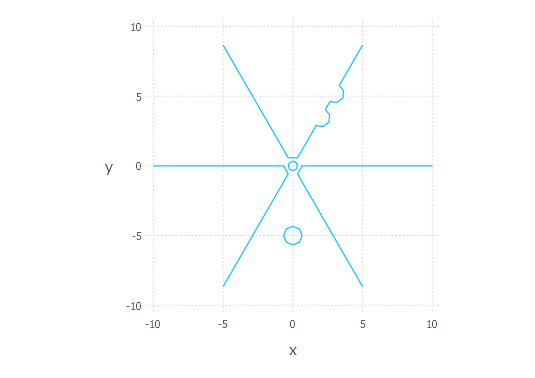

In [435]:
n = 3
a = im
# zeroList = [1+sqrt(3)*im, 2+2*sqrt(3)*im, 0+0*im, 0+5*im, 0-5*im]
zeroList = [3+3*sqrt(3)*im, 2+2*sqrt(3)*im, 0+0*im, 0+5*im, 0-5*im]
(gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus) = get_gamma(a, n, zeroList)
gamma = collect(Iterators.flatten([gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus]))
# gamma = [gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus]
plot_contour(gamma)

## `solve_IBVP(L, U, a, zeroList, f; pDerivMatrix, infty)`

Computes the solution
\begin{align*}
q(x,t) &= f_x\left(e^{-a\lambda^n t}F_\lambda(f)\right)\\
&= \int_{\Gamma_0^+}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^+(f)\,d\lambda + \int_{\Gamma_a^+}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^+(f)\,d\lambda + \int_{\Gamma_0^-}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^-(f)\,d\lambda + \int_{\Gamma_a^-}e^{i\lambda x}e^{-a\lambda^n t}F_\lambda^-(f)\,d\lambda.
\end{align*}

In [452]:
# Function to solve a given IBVP with given L, U, and f (p15 (3.2)), where f is as in 2.12b (initial condition q(x,0))
# pDerivMatrix in this case would be user input but it's all zeroes
function solve_IBVP(L::LinearDifferentialOperator, U::VectorBoundaryForm, a::Number, zeroList::Array, f::Function; pDerivMatrix = get_pDerivMatrix(L), infty = INFTY)
    n = length(L.pFunctions)-1
    adjointU = get_adjointU(L, U, pDerivMatrix)
    (gammaAPlus, gammaAMinus, gamma0Plus, gamma0Minus) = find_gamma(a, n, zeroList, infty)
    function q(x,t)
        (FPlusLambda, FMinusLambda) = get_FPlusMinusLambda(adjointU; symbolic = false, lambda)
        integrandPlus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * FPlusLambda(f) # F^+_\lambda(f) is a number for a given f
        integrandMinus(lambda) = e^(im*lambda*x)*e^(-a*lambda^n*t) * FMinusLambda(f)
        println(integrandPlus(1+im))
        println(integrandMinus(1+im))
        integralGamma0Plus = quadgk(integrandPlus, gamma0Plus...)[1]
        println("int_0_+ = $integralGamma0Plus")
        integralGammaAPlus = quadgk(integrandPlus, gammaAPlus...)[1]
        println("int_a_+ = $integralGammaAPlus")
        integralGamma0Minus = quadgk(integrandMinus, gamma0Minus...)[1]
        println("int_0_- = $integralGamma0Minus")
        integralGammaAMinus = quadgk(integrandMinus, gammaAMinus...)[1]
        println("int_a_- = $integralGammaAMinus")
        return (integralGamma0Plus + integralGammaAPlus + integralGamma0Minus + integralGammaAMinus)
    end
    return q
end

solve_IBVP (generic function with 1 method)

$n=2$, $a=e^{i\theta}$ for $\theta\in [-\frac{\pi}{2}, \frac{\pi}{2}]$.
\begin{align*}
\begin{cases}
\varphi(0) + \beta_0\varphi(1) &= 0\\
\varphi'(0) + \beta_1\varphi'(1) &= 0\quad\mbox{$\beta_0, \beta_1\in\hat{\mathbb{C}}$},
\end{cases}\\
\begin{cases}
\varphi(0) + b_0\varphi'(0) &= 0\\
\varphi(1) + b_1\varphi'(1) &= 0\quad\mbox{$b_0, b_1\in\hat{\mathbb{C}}$}.
\end{cases}
\end{align*}

\begin{align*}
[\partial_t-\partial^2_x]q(x,t) &= 0\\
q(x, 0) &= 0,
\end{align*}

\begin{align*}
\begin{cases}
q(\cdot, t)(0) + q(\cdot, t)(1) + 0\cdot q(\cdot, t)^{(1)}(0) + 0\cdot q(\cdot, t)^{(1)}(1)  &= 0\\
0\cdot q(\cdot, t)(0) + 0\cdot q(\cdot, t)(1) + q(\cdot, t)^{(1)}(0) + q(\cdot, t)^{(1)}(1) &= 0
\end{cases}
\end{align*}

In [453]:
t = symbols("t")
symPFunctions = [-1 0 0]
interval = (0, 1)
symL = SymLinearDifferentialOperator(symPFunctions, interval, t)
# pFunctions = [t->1 t->t+1 t->t^2+t+1]
# L = LinearDifferentialOperator(pFunctions, interval, symL)
L = get_L(symL)

M = [1 0; 0 1]
N = [1 0; 0 1]
U = VectorBoundaryForm(M, N)

f(x) = 0

f (generic function with 1 method)

In [454]:
adjointU = get_adjointU(L, U)
a = 1+im

1 + 1im

In [311]:
delta = get_delta(adjointU; symbolic = true)
separatedDelta = separate_real_imaginary(delta)

LoadError: [91mUndefVarError: clean_up_float not defined[39m

In [ ]:
solve_IBVP(L, U, a, zeroList, f)